#### Planteamiento del Problema

Se desea predecir la cantidad de puntos que pueda hacer un jugador en un partido, 
a partir de estadísticas personales (del jugador) y colectivas (del equipo en donde juega). 

Imports

In [2]:
#Se importan todas las dependencias necesarias
import pandas as pd
import sqlite3
import numpy as np
import scipy.stats
from scipy.stats import skew, kurtosis
from nba_api.stats.endpoints import playergamelogs, teamgamelogs, teamgamelog
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import re

Obtenemos las estadísticas de los jugadores por partidos en las temporadas 2020-21, 2021-22 y 2022-23

In [2]:
season0_players = playergamelogs.PlayerGameLogs(season_nullable='2020-21') #Consulta para temporada 2020-21
season1_players = playergamelogs.PlayerGameLogs(season_nullable='2021-22') #Consulta para temporada 2021-22
season2_players = playergamelogs.PlayerGameLogs(season_nullable='2022-23') #Consulta para temporada 2022-23
players = pd.concat([season0_players.get_data_frames()[0],season1_players.get_data_frames()[0],season2_players.get_data_frames()[0]], ignore_index=True) #Dataframe de estadísticas de jugadores por partido en las tres temporadas
players.head()

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG
0,2020-21,1626169,Stanley Johnson,Stanley,1610612761,TOR,Toronto Raptors,0022001079,2021-05-16T00:00:00,TOR vs. IND,...,15321,4919,795,1773,17520,2490,1849,143,1612,1
1,2020-21,1629052,Oshae Brissett,Oshae,1610612754,IND,Indiana Pacers,0022001079,2021-05-16T00:00:00,IND @ TOR,...,1,16132,795,560,3883,1231,1,143,808,1
2,2020-21,203083,Andre Drummond,Andre,1610612747,LAL,Los Angeles Lakers,0022001072,2021-05-16T00:00:00,LAL @ NOP,...,1,21997,2281,7127,11703,2950,1,143,3790,1
3,2020-21,202685,Jonas Valanciunas,Jonas,1610612763,MEM,Memphis Grizzlies,0022001070,2021-05-16T00:00:00,MEM @ GSW,...,15321,10833,2281,787,20143,774,1,143,898,1
4,2020-21,1628981,Bruno Fernando,Bruno,1610612737,ATL,Atlanta Hawks,0022001066,2021-05-16T00:00:00,ATL vs. HOU,...,20949,4919,6289,9732,3883,6572,1849,143,8016,1


Obtenemos las estadísticas de los equipos por partidos en las temporadas 2020-21, 2021-22 y 2022-23

In [3]:
season0_teams = teamgamelogs.TeamGameLogs(season_nullable='2020-21') #Consulta para temporada 2020-21
season1_teams = teamgamelogs.TeamGameLogs(season_nullable='2021-22') #Consulta para temporada 2021-22
season2_teams = teamgamelogs.TeamGameLogs(season_nullable='2022-23') #Consulta para temporada 2022-23
teams = pd.concat([season0_teams.get_data_frames()[0],season1_teams.get_data_frames()[0],season2_teams.get_data_frames()[0]], ignore_index=True) #Dataframe de estadísticas de equipos por partido en las tres temporadas
teams.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG
0,2020-21,1610612766,CHA,Charlotte Hornets,0022001080,2021-05-16T00:00:00,CHA @ WAS,L,48.0,37,...,938,826,751,801,332,247,786,1180,1305,1
1,2020-21,1610612749,MIL,Milwaukee Bucks,0022001068,2021-05-16T00:00:00,MIL @ CHI,L,48.0,38,...,2131,641,66,801,1868,376,786,1031,1373,1
2,2020-21,1610612746,LAC,LA Clippers,0022001074,2021-05-16T00:00:00,LAC @ OKC,L,48.0,45,...,2014,2,751,1499,2140,154,2113,1031,1305,1
3,2020-21,1610612743,DEN,Denver Nuggets,0022001076,2021-05-16T00:00:00,DEN @ POR,L,48.0,44,...,1741,14,751,1830,1361,1160,1609,762,1848,1
4,2020-21,1610612738,BOS,Boston Celtics,0022001073,2021-05-16T00:00:00,BOS @ NYK,L,48.0,35,...,1857,641,1867,490,1361,942,1437,2049,1238,1


Agregamos la columna PTSR (Puntos recibidos) por el equipo en cada partido, temporadas 2020-21, 2021-22 y 2022-23. 

Sería restar los puntos realizados menos la diferencia final de puntaje respecto al otro equipo una vez finalizado el partido.

In [4]:
teams['PTSR'] = (teams['PTS'] - teams['PLUS_MINUS']).astype(int)
teams.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,PTSR
0,2020-21,1610612766,CHA,Charlotte Hornets,0022001080,2021-05-16T00:00:00,CHA @ WAS,L,48.0,37,...,826,751,801,332,247,786,1180,1305,1,115
1,2020-21,1610612749,MIL,Milwaukee Bucks,0022001068,2021-05-16T00:00:00,MIL @ CHI,L,48.0,38,...,641,66,801,1868,376,786,1031,1373,1,118
2,2020-21,1610612746,LAC,LA Clippers,0022001074,2021-05-16T00:00:00,LAC @ OKC,L,48.0,45,...,2,751,1499,2140,154,2113,1031,1305,1,117
3,2020-21,1610612743,DEN,Denver Nuggets,0022001076,2021-05-16T00:00:00,DEN @ POR,L,48.0,44,...,14,751,1830,1361,1160,1609,762,1848,1,132
4,2020-21,1610612738,BOS,Boston Celtics,0022001073,2021-05-16T00:00:00,BOS @ NYK,L,48.0,35,...,641,1867,490,1361,942,1437,2049,1238,1,96


Hacemos una nueva consulta a la API con otro endpoint para poder obtener el W_PCT o % de Victorias del equipo

In [5]:
teams_list = teams.TEAM_ID.unique().tolist() #El for será para encontrar el W_PCT de todos los equipos para cada partido de la temporada
teamLog = pd.DataFrame() #inicializamos para que no quede basura

for team in teams_list:
    teamLog0 = teamgamelog.TeamGameLog(season='2020-21',team_id=team) #Consulta para temporada 2020-21
    teamLog1 = teamgamelog.TeamGameLog(season='2021-22',team_id=team) #Consulta para temporada 2021-22
    teamLog2 = teamgamelog.TeamGameLog(season='2022-23',team_id=team) #Consulta para temporada 2022-23
    teamLog3 = pd.concat([teamLog0.get_data_frames()[0], teamLog1.get_data_frames()[0], teamLog2.get_data_frames()[0]],ignore_index=True) #En cada ciclo se forma el dataframe por equipo por partido en las tres temporadas 
    teamLog  = pd.concat([teamLog, teamLog3]) #Se van consolidando en un dataframe las consultas para todos los equipos

In [6]:
teamLog.head()

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612766,0022001080,"MAY 16, 2021",CHA @ WAS,L,33,39,0.458,240,37,...,0.917,10,32,42,25,8,5,11,15,110
1,1610612766,0022001064,"MAY 15, 2021",CHA @ NYK,L,33,38,0.465,265,39,...,0.750,15,36,51,28,5,2,8,18,109
2,1610612766,0022001047,"MAY 13, 2021",CHA vs. LAC,L,33,37,0.471,240,33,...,0.789,8,27,35,24,9,1,10,15,90
3,1610612766,0022000448,"MAY 11, 2021",CHA vs. DEN,L,33,36,0.478,240,42,...,0.850,15,34,49,30,9,5,17,17,112
4,1610612766,0022001020,"MAY 09, 2021",CHA vs. NOP,L,33,35,0.485,240,42,...,0.722,11,35,46,22,6,8,17,19,110


In [7]:
#Se renombran las columnas de con el mismo titulo que en el dataframe de teams, para poder hacer el merge deseado (filtrando por las columnas GAME_ID y TEAM_ID)
teamLog = teamLog.rename(columns={'Game_ID': 'GAME_ID'})
teamLog = teamLog.rename(columns={'Team_ID': 'TEAM_ID'})

In [8]:
#Se hace el merge deseado de W_PCT (% Victorias) filtrando por las columnas GAME_ID y TEAM_ID
merged_df = pd.merge(teams,teamLog, on=['GAME_ID','TEAM_ID'], how='left')
teams['W_PCT'] = merged_df['W_PCT']
teams.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,PTSR,W_PCT
0,2020-21,1610612766,CHA,Charlotte Hornets,0022001080,2021-05-16T00:00:00,CHA @ WAS,L,48.0,37,...,751,801,332,247,786,1180,1305,1,115,0.458
1,2020-21,1610612749,MIL,Milwaukee Bucks,0022001068,2021-05-16T00:00:00,MIL @ CHI,L,48.0,38,...,66,801,1868,376,786,1031,1373,1,118,0.639
2,2020-21,1610612746,LAC,LA Clippers,0022001074,2021-05-16T00:00:00,LAC @ OKC,L,48.0,45,...,751,1499,2140,154,2113,1031,1305,1,117,0.653
3,2020-21,1610612743,DEN,Denver Nuggets,0022001076,2021-05-16T00:00:00,DEN @ POR,L,48.0,44,...,751,1830,1361,1160,1609,762,1848,1,132,0.653
4,2020-21,1610612738,BOS,Boston Celtics,0022001073,2021-05-16T00:00:00,BOS @ NYK,L,48.0,35,...,1867,490,1361,942,1437,2049,1238,1,96,0.500


In [9]:
#Para comprobar que no hayan quedado valores que no hayan hecho math entre columna GAME_ID y TEAM_ID
#Si fuese el caso, se hubiese rellenado con NaN
teams.W_PCT.isna().any()

False

Obtenemos un solo DataFrame con las columnas que necesitamos, se va a consolidar todo en el Dataframe de estadísticas de los jugadores "players"

In [10]:
#Del Dataframe "teams" se obtienen las columnas de Puntos recibidos por el equipo 'PTSR', 'PTS' Puntos realizados por el equipo y W_PCT (%Victorias)
#Se hace el merge deseado de Puntos recibidos por el equipo 'PTSR', 'PTS' Puntos realizados por el equipo y W_PCT (%Victorias); filtrando por las columnas GAME_ID y TEAM_ID
teams = teams.rename(columns={'PTS': 'PTSTeam'}) #Porque en el Dataframe players tambien hay una columna PTS

merged_df2 = pd.merge(players,teams, on=['GAME_ID','TEAM_ID'], how='left')

players[['PTSRTeam','PTSTeam','W_PCTTeam']] = merged_df2[['PTSR','PTSTeam','W_PCT']] #Se crean las nuevas columnas en el Dataframe players de acuerdo al merge realizado.

players.head()

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,PTSRTeam,PTSTeam,W_PCTTeam
0,2020-21,1626169,Stanley Johnson,Stanley,1610612761,TOR,Toronto Raptors,0022001079,2021-05-16T00:00:00,TOR vs. IND,...,1773,17520,2490,1849,143,1612,1,125,113,0.375
1,2020-21,1629052,Oshae Brissett,Oshae,1610612754,IND,Indiana Pacers,0022001079,2021-05-16T00:00:00,IND @ TOR,...,560,3883,1231,1,143,808,1,113,125,0.472
2,2020-21,203083,Andre Drummond,Andre,1610612747,LAL,Los Angeles Lakers,0022001072,2021-05-16T00:00:00,LAL @ NOP,...,7127,11703,2950,1,143,3790,1,98,110,0.583
3,2020-21,202685,Jonas Valanciunas,Jonas,1610612763,MEM,Memphis Grizzlies,0022001070,2021-05-16T00:00:00,MEM @ GSW,...,787,20143,774,1,143,898,1,113,101,0.528
4,2020-21,1628981,Bruno Fernando,Bruno,1610612737,ATL,Atlanta Hawks,0022001066,2021-05-16T00:00:00,ATL vs. HOU,...,9732,3883,6572,1849,143,8016,1,95,124,0.569


In [11]:
#Para comprobar que no hayan quedado valores que no hayan hecho math entre columna GAME_ID y TEAM_ID
#Si fuese el caso, se hubiese rellenado con NaN
print(players.PTSRTeam.isna().any())
print(players.PTSTeam.isna().any())
print(players.W_PCTTeam.isna().any())

False
False
False


Se agrega una nueva columna para determinar si un equipo es local o visitante

In [12]:
def determinar_tipo(data):
    if '@' in data:
        return 'A'  # Si hay '@', entonces es visitante
    elif 'vs' in data:
        return 'H'  # Si hay 'vs', entonces es local
    
players['HOME_AWAY'] = players['MATCHUP'].apply(determinar_tipo) #Nueva columna Home (H), Away (A)

players.head(2)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,PTSRTeam,PTSTeam,W_PCTTeam,HOME_AWAY
0,2020-21,1626169,Stanley Johnson,Stanley,1610612761,TOR,Toronto Raptors,0022001079,2021-05-16T00:00:00,TOR vs. IND,...,17520,2490,1849,143,1612,1,125,113,0.375,H
1,2020-21,1629052,Oshae Brissett,Oshae,1610612754,IND,Indiana Pacers,0022001079,2021-05-16T00:00:00,IND @ TOR,...,3883,1231,1,143,808,1,113,125,0.472,A


Removemos las columnas que no se utilizarán en la generación del modelo predictivo.

In [14]:
#Remocion de columnas
players = players.drop(['WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK',
       'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK',
       'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK',
       'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK',
       'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK',
       'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
       'WNBA_FANTASY_PTS_RANK','NBA_FANTASY_PTS', 'DD2',
       'TD3'], axis = 1)

players.head(2)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,BLKA,PF,PFD,PTS,PLUS_MINUS,AVAILABLE_FLAG,PTSRTeam,PTSTeam,W_PCTTeam,HOME_AWAY
0,2020-21,1626169,Stanley Johnson,Stanley,1610612761,TOR,Toronto Raptors,0022001079,2021-05-16T00:00:00,TOR vs. IND,...,1,1,6,24,-8,1,125,113,0.375,H
1,2020-21,1629052,Oshae Brissett,Oshae,1610612754,IND,Indiana Pacers,0022001079,2021-05-16T00:00:00,IND @ TOR,...,0,3,6,31,10,1,113,125,0.472,A


Tomamos el promedio de los últimos 5 partidos para las estadísticas por jugador

In [15]:
#Ordenar el Dataframe de forma ascendente en base a las columnas descritas.
players = players.sort_values(by=['SEASON_YEAR','PLAYER_ID','GAME_DATE'], ascending=[True,True,True])

In [16]:
#Hacemos reset el indice del dataframe en caso de que lo podamos necesitar en orden
players = players.reset_index(drop=True)

In [ ]:
def calcular_promedio_puntos(dataframe, columna, player_id, game_date, n_partidos):
    """
    Calcula el promedio de puntos de un jugador en los N partidos anteriores, excluyendo el partido actual.
    Parámetros:
      dataframe: El dataframe con los datos de los jugadores.
      game_date: El GAME_ID del partido actual.
      player_id: El PLAYER_ID del jugador para el que se quiere calcular el promedio.
      n_partidos: El número de partidos anteriores a considerar.
      columna: La columna que contiene los puntos del jugador.
    Devuelve:
      El promedio de puntos del jugador en los N partidos anteriores.
    """
    # Filtrar el dataframe para los partidos anteriores al actual y del jugador específico
    partidos_anteriores_jugador = dataframe[(dataframe['GAME_DATE'] < game_date) & (dataframe['PLAYER_ID'] == player_id)]
    
    # Si no hay suficientes partidos anteriores para el jugador, tomar los partidos disponibles
    n_partidos_disponibles = min(len(partidos_anteriores_jugador), n_partidos)
    
    # Si hay al menos un partido anterior, calcular el promedio de puntos
    if n_partidos_disponibles > 0:
        promedio_puntos = partidos_anteriores_jugador.tail(n_partidos_disponibles)[columna].mean()
    else:
        # Si no hay partidos anteriores disponibles, tomar el valor del partido actual
        promedio_puntos = dataframe[(dataframe['GAME_DATE'] == game_date) & (dataframe['PLAYER_ID'] == player_id)][columna].iloc[0]
    
    return promedio_puntos

#Lista de columnas para las cuales se obtendrán las estadísticas promediadas
lista_columnas_para_promedio = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'PTSRTeam',
       'PTSTeam', 'W_PCTTeam']

#Tomamos una listas de los jugadores y de las fechas de los partidos.
jugadores_ID = players.PLAYER_ID.unique().tolist()
dates = players.GAME_DATE.unique().tolist()


n_partidos = 5 #numero de partidos para sacar el promedio

#Se llama a la funcion para obtener las estadisticas promediadas de todos los jugadores
for columna in lista_columnas_para_promedio:
  for jugador in jugadores_ID:
      for date in dates:
        
        indice = players.index[(players['GAME_DATE']==date) & (players['PLAYER_ID']==jugador)]

        if indice.empty:
                # Si no se encontró un índice válido, pasar a la siguiente fecha
          continue

        promedio = calcular_promedio_puntos(players, columna, jugador, date, n_partidos)

        if promedio is None:
                # Pasar a la siguiente fecha
          continue
              
        players.loc[indice,columna+'_'+'PROM'] = promedio

Guardado de dataframe en un archivo .csv

In [ ]:
#se guarda el dataframe en el archivo .csv llamado "data_complete_raw.csv"
players.to_csv('/workspace/ProyectoDS/data/raw/data_complete_raw.csv', index=False)

Enviamos los registros a una DB.

In [3]:
players = pd.read_csv('/workspaces/ProyectoDS/data/raw/data_complete_raw.csv')

# Se crea una base de datos llamada "NBA.db" que contendrá los datos del archivo .csv guardado previamente
con = sqlite3.connect("NBA.db")
con.execute("DROP TABLE IF EXISTS ESTADISTICAS;")
players.to_sql('ESTADISTICAS',con, index=False)

con.close()

In [4]:
con = sqlite3.connect("NBA.db")
cur = con.cursor()

# -- Obtenemos los 10 máximos anotadores.
cur.execute("""SELECT SEASON_YEAR, PLAYER_NAME, TEAM_NAME,
            PTS, FGM, FGA, FG_PCT,FG3M, FG3A, FG3_PCT
            FROM ESTADISTICAS
            ORDER BY PTS DESC
            LIMIT 10
            ;

            """)

res = cur.fetchall()

for row in res:
    print(f"Temporada: {row[0]}")
    print(f"Nombre: {row[1]}")
    print(f"Equipo: {row[2]}")
    print(f"Puntos: {row[3]}")
    print(f"Tiros convertidos: {row[4]}/{row[5]}")
    print(f"Porcentaje de aciertos: {row[6]}")
    print(f"Tiros de 3: {row[7]}/{row[8]}")
    print(f"Porcentaje tiros de 3: {row[9]}\n\n")

Temporada: 2022-23
Nombre: Damian Lillard
Equipo: Portland Trail Blazers
Puntos: 71
Tiros convertidos: 22/38
Porcentaje de aciertos: 0.579
Tiros de 3: 13/22
Porcentaje tiros de 3: 0.591


Temporada: 2022-23
Nombre: Donovan Mitchell
Equipo: Cleveland Cavaliers
Puntos: 71
Tiros convertidos: 22/34
Porcentaje de aciertos: 0.647
Tiros de 3: 7/15
Porcentaje tiros de 3: 0.467


Temporada: 2020-21
Nombre: Stephen Curry
Equipo: Golden State Warriors
Puntos: 62
Tiros convertidos: 18/31
Porcentaje de aciertos: 0.581
Tiros de 3: 8/16
Porcentaje tiros de 3: 0.5


Temporada: 2020-21
Nombre: Bradley Beal
Equipo: Washington Wizards
Puntos: 60
Tiros convertidos: 20/35
Porcentaje de aciertos: 0.571
Tiros de 3: 7/10
Porcentaje tiros de 3: 0.7


Temporada: 2020-21
Nombre: Jayson Tatum
Equipo: Boston Celtics
Puntos: 60
Tiros convertidos: 20/37
Porcentaje de aciertos: 0.541
Tiros de 3: 5/7
Porcentaje tiros de 3: 0.714


Temporada: 2021-22
Nombre: Kyrie Irving
Equipo: Brooklyn Nets
Puntos: 60
Tiros convertid

In [5]:
# -- Obtenemos los puntos de jugador por temporada (máximos anotadores en una temporada).
cur.execute("""SELECT PLAYER_NAME, TEAM_NAME, SEASON_YEAR,
              SUM(PTS) AS PTS_TOT
              FROM ESTADISTICAS
              GROUP BY PLAYER_NAME, TEAM_NAME, SEASON_YEAR
              ORDER BY PTS_TOT DESC
              LIMIT 10""")

res = cur.fetchall()

for row in res:
        print(f"Nombre: {row[0]}")
        print(f"Equipo: {row[1]}")
        print(f"Temporada: {row[2]}")
        print(f"Puntos totales: {row[3]}\n\n")

con.close()

Nombre: Jayson Tatum
Equipo: Boston Celtics
Temporada: 2022-23
Puntos totales: 2225


Nombre: Joel Embiid
Equipo: Philadelphia 76ers
Temporada: 2022-23
Puntos totales: 2183


Nombre: Trae Young
Equipo: Atlanta Hawks
Temporada: 2021-22
Puntos totales: 2155


Nombre: Luka Doncic
Equipo: Dallas Mavericks
Temporada: 2022-23
Puntos totales: 2138


Nombre: Shai Gilgeous-Alexander
Equipo: Oklahoma City Thunder
Temporada: 2022-23
Puntos totales: 2135


Nombre: DeMar DeRozan
Equipo: Chicago Bulls
Temporada: 2021-22
Puntos totales: 2118


Nombre: Joel Embiid
Equipo: Philadelphia 76ers
Temporada: 2021-22
Puntos totales: 2079


Nombre: Jayson Tatum
Equipo: Boston Celtics
Temporada: 2021-22
Puntos totales: 2046


Nombre: Stephen Curry
Equipo: Golden State Warriors
Temporada: 2020-21
Puntos totales: 2015


Nombre: Nikola Jokic
Equipo: Denver Nuggets
Temporada: 2021-22
Puntos totales: 2004




Análisis Descriptivo Variables Numéricas

In [6]:
columns_exclude = ['PLAYER_ID','TEAM_ID','GAME_ID']
numeric_columns = players.select_dtypes(exclude=['object', 'category']).columns
numeric_columns = [col for col in numeric_columns if col not in columns_exclude]

Se muestra la media, mínimo, máximo, rango, desviación estándar, cuartiles, asimetría, curtosis y moda.
Esto para las variables numéricas.

In [7]:
estadisticas_desc = []
for column_name in numeric_columns:
    mean = players[column_name].mean()
    min = players[column_name].min()
    max = players[column_name].max()
    moda = players[column_name].mode()
    rang = max - min 
    std = players[column_name].std()
    skewness = skew(players[column_name])
    cuartil_25 = np.percentile(players[column_name],25)
    cuartil_50 = np.percentile(players[column_name],50)
    cuartil_75 = np.percentile(players[column_name],75)
    kurtosis = scipy.stats.kurtosis(players[column_name])

    estadisticas_desc.append([column_name, mean, moda, min, max, rang, std, cuartil_25, cuartil_50, cuartil_75, kurtosis, skewness])

headers = ["Columna", "Media", "Moda", "Mínimo", "Máximo", "Rango", "Desviación estándar", "Cuartil 25", "Cuartil 50", "Cuartil 75", "Kurtosis", "Asimetría"]
print(tabulate(estadisticas_desc, headers=headers, tablefmt="grid"))

+-----------------+-------------+-----------+-------------+----------+----------+-----------------------+--------------+--------------+--------------+---------------+-------------+
| Columna         |       Media |      Moda |      Mínimo |   Máximo |    Rango |   Desviación estándar |   Cuartil 25 |   Cuartil 50 |   Cuartil 75 |      Kurtosis |   Asimetría |
+=================+=============+===========+=============+==========+==========+=======================+==============+==============+==============+===============+=============+
| MIN             |  22.8053    |  12       |   0         |  56.5167 |  56.5167 |            10.7069    |    15.1833   |      23.7383 |      31.5133 |   -0.805723   |  -0.278994  |
+-----------------+-------------+-----------+-------------+----------+----------+-----------------------+--------------+--------------+--------------+---------------+-------------+
| FGM             |   3.89681   |   1       |   0         |  22      |  22      |             3

/home/vscode/.local/lib/python3.10/site-packages/tabulate/__init__.py:827: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  conv(string)
/home/vscode/.local/lib/python3.10/site-packages/tabulate/__init__.py:1232: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return format(float(val), floatfmt)


Dentro de las apreciaciones iniciales se puede observar que:

-   MIN: 
    - Los jugadores juegan una media de 22.8 minutos por partido.
    - La cantidad de minutos jugados por partido que más se repite es de 12 minutos.
    - La mayor cantidad de minutos que jugó un jugador en un partido fue de 56.5 minutos.

-   FGM: 
    - Los jugadores aciertan una media de aprox. 4 tiros de campo por partido. 
    - La mayor cantidad de tiros de campos acertados en un partido fue de 22.
    - La cantidad de tiros de campo acertados por partido que más se repite es de 1.

-   FTM:
    - Los jugadores aciertan una media de aprox. 2 tiros libres por partido. 
    - La mayor cantidad de tiros libres acertados en un partido fue de 23.

-   PF y PFD:
    - Los jugadores cometen y reciben una media de aprox. 2 faltas por partido. 
    - La cantidad de faltas cometidas por partido que más se repite es de 1.
    - La mayor cantidad de fatas recibidas por un jugador en un partido fue de 19.

-   PTS:
    - La mayor cantidad de puntos anotadas por un jugador en un partido fue de 71 puntos.
    - Los jugadores anotan una media de aprox. 11 puntos por partido.
    
-   PTSTeam y PTSRTeam:
    - La mayor cantidad de puntos hechos y recibidos por equipos en un partido fue de 176.
    - La menor cantidad de puntos hechos y recibidos por equipos en un partido fue de 73.
    - Los equipos hacen y reciben una media de 113 puntos por partido.

Analizamos las variables categóricas

In [8]:
categ_columns = players.select_dtypes(include=['object','category']).columns
categ_columns = categ_columns.tolist()
categ_columns.append('AVAILABLE_FLAG')
categ_columns

['SEASON_YEAR',
 'PLAYER_NAME',
 'NICKNAME',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'HOME_AWAY',
 'AVAILABLE_FLAG']

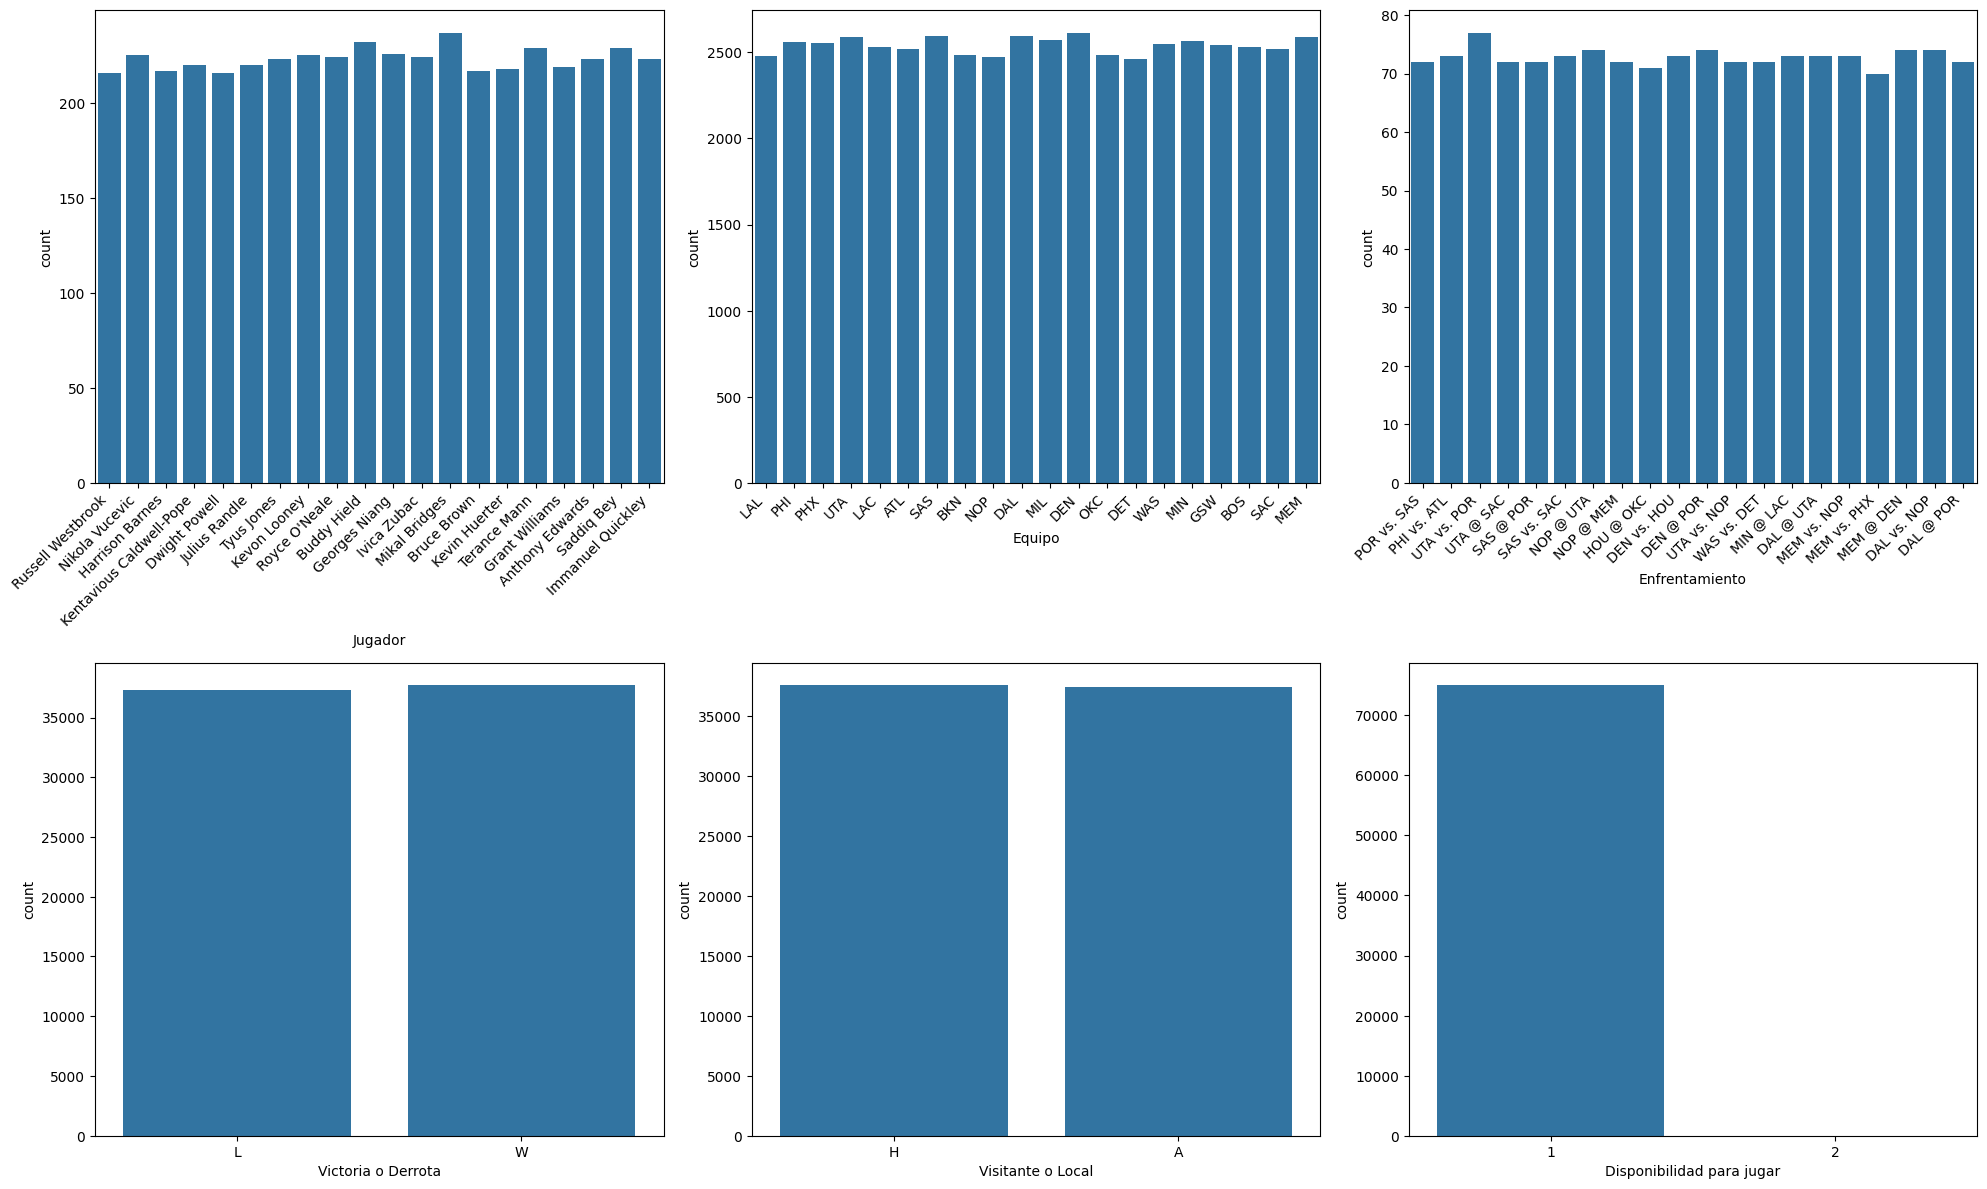

In [9]:
# Filtrar el DataFrame original para incluir solo los datos de los 20 jugadores que más partidos jugaron
top_20_jugadores = players['PLAYER_NAME'].value_counts().head(20).index
top_20_jugadores = players[players['PLAYER_NAME'].isin(top_20_jugadores)]

# Filtrar el DataFrame original para incluir solo los datos de los 20 enfrentamientos más repetidos
# de acuerdo a los registros de partidos jugador por sus jugadores
top_20_matchup = players['MATCHUP'].value_counts().head(20).index
top_20_matchup = players[players['MATCHUP'].isin(top_20_matchup)]

# Filtrar el DataFrame original para incluir solo los datos de los 20 equipos para los cuales hay más registros
# de partidos jugados por sus jugadores
top_20_team = players['TEAM_ABBREVIATION'].value_counts().head(20).index
top_20_team = players[players['TEAM_ABBREVIATION'].isin(top_20_team)]

fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Countplot para variables categóricas
sns.countplot(x='PLAYER_NAME', data=top_20_jugadores, ax=axs[0, 0]).set(xlabel = 'Jugador')
sns.countplot(x='TEAM_ABBREVIATION', data=top_20_team, ax=axs[0, 1]).set(xlabel = 'Equipo')
sns.countplot(x='MATCHUP', data=top_20_matchup, ax=axs[0, 2]).set(xlabel = 'Enfrentamiento')

for ax in axs[0, :]:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


sns.countplot(x='WL', data=players, ax=axs[1, 0]).set(xlabel = 'Victoria o Derrota')
sns.countplot(x='HOME_AWAY', data=players, ax=axs[1, 1]).set(xlabel='Visitante o Local')
sns.countplot(x='AVAILABLE_FLAG', data=players, ax=axs[1, 2]).set(xlabel='Disponibilidad para jugar')

plt.tight_layout()
# Mostrar los gráficos
plt.show()

In [10]:
top_20_jugadores = players['PLAYER_NAME'].value_counts().head(3)
print(top_20_jugadores)
print()
top_20_matchup = players['MATCHUP'].value_counts().head(3)
print(top_20_matchup)
print()
top_20_team = players['TEAM_ABBREVIATION'].value_counts().head(3)
print(top_20_team)

PLAYER_NAME
Mikal Bridges    237
Buddy Hield      232
Terance Mann     229
Name: count, dtype: int64

MATCHUP
UTA vs. POR    77
MEM @ DEN      74
NOP @ UTA      74
Name: count, dtype: int64

TEAM_ABBREVIATION
DEN    2614
DAL    2594
SAS    2592
Name: count, dtype: int64


- El jugador que más partidos acumuló en las tres temporadas fue "Mikal Bridges" y le sigue "Buddy Hield" ambos con más de 230 partidos.
- El enfrentamiento más repetido en las tres temporadas fue el de Utah Jazz versus Portland Trail Blazers con 77 encuentros (de acuerdo al registro de los jugadores por partido).
- El equipo que más encuentros tuvo en las tres temporadas fue Denver Nuggets (de acuerdo al registro de los jugadores por partido).
- Como era de esperarse la estadística recolectada presenta cantidad bastante cercana entre juego Ganados y Perdidos, situación similar ocurre para el caso de juegos de Visitante y Local.
- Se nota que en la inmensa mayoría de los casos, los jugadores estuvieron disponibles para jugar cada partido.

Análisis Exploratorio de Datos

In [11]:
# Primera apreciacion del dataset
filas = players.shape[0]
columnas = players.shape[1]
print(f'Filas: {filas} | Columnas: {columnas}')
print()
print(players.info())

Filas: 74987 | Columnas: 63

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74987 entries, 0 to 74986
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_YEAR        74987 non-null  object 
 1   PLAYER_ID          74987 non-null  int64  
 2   PLAYER_NAME        74987 non-null  object 
 3   NICKNAME           74987 non-null  object 
 4   TEAM_ID            74987 non-null  int64  
 5   TEAM_ABBREVIATION  74987 non-null  object 
 6   TEAM_NAME          74987 non-null  object 
 7   GAME_ID            74987 non-null  int64  
 8   GAME_DATE          74987 non-null  object 
 9   MATCHUP            74987 non-null  object 
 10  WL                 74987 non-null  object 
 11  MIN                74987 non-null  float64
 12  FGM                74987 non-null  int64  
 13  FGA                74987 non-null  int64  
 14  FG_PCT             74987 non-null  float64
 15  FG3M               74987 non-null  int64 

In [12]:
nulos = players.isnull().any().sum()
if nulos != 0:
    print(f'Hay {nulos} datos nulos')    
else:
    print("No hay datos nulos en ninguna columna")

No hay datos nulos en ninguna columna


- Se puede apreciar que no existen datos faltantes/nulos en ninguna de las variables, además contamos con 74987 registros y 63 variables incluyendo la variable a predecir.
- Hay 11 variables categóricas, las cuales son SEASON_YEAR, PLAYER_ID, PLAYER_NAME, NICKNAME, TEAM_ID, TEAM_ABBREVIATION, TEAM_NAME, GAME_ID, GAME_DATE, MATCHUP, WL; a pesar de que PLAYER_ID, TEAM_ID y GAME_ID están en números.
- Hay 52 variables numéricas. Entre ellas la variable a predecir que es "PTS", la cual se refiere a los puntos por partido de cada jugador. 

In [13]:
#Se verifica la existencia de valores duplicados
#No puede existir más de un registro de un jugador de un mismo juego
duplicates = players.duplicated(subset=['PLAYER_ID','GAME_ID']).sum()

if duplicates != 0:
    print(f'Existen {duplicates} datos duplicados.')
else:
    print(f'No existen datos duplicados')

No existen datos duplicados


In [14]:
#Se crean diccionarios para el nombre de los equipos y su abreviación, y para el nombre de los jugadores
team_name_dict = players.groupby('TEAM_ID')['TEAM_NAME'].first().to_dict()
team_abbre_dict = players.groupby('TEAM_ID')['TEAM_ABBREVIATION'].first().to_dict()
players_dict = players.groupby('PLAYER_ID')['PLAYER_NAME'].first().to_dict()

Se eliminará la información irrelevante, redundante o que no se adapte de acuerdo al tipo de modelo que buscamos entrenar.

In [15]:
#De cara al despliegue variables como SEASON_YEAR y GAME_DATE no son relevantes porque el usuario 
#predecirá en una nueva temporada, PLAYER_NAME y NICKNAME ya contenidas en PLAYER_ID
#TEAM_ABBREVIATION y TEAM_NAME ya contenidas en TEAM_ID, GAME_ID es irrelevante, REB_PROM es una combinación
#entre OREB_PROM y DREB_PROM
players_data = players.drop(['SEASON_YEAR','PLAYER_NAME','NICKNAME','TEAM_ABBREVIATION',
                             'TEAM_NAME','GAME_ID','GAME_DATE','REB_PROM'], axis = 1)
players_data.columns

Index(['PLAYER_ID', 'TEAM_ID', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS',
       'PLUS_MINUS', 'AVAILABLE_FLAG', 'PTSRTeam', 'PTSTeam', 'W_PCTTeam',
       'HOME_AWAY', 'MIN_PROM', 'FGM_PROM', 'FGA_PROM', 'FG_PCT_PROM',
       'FG3M_PROM', 'FG3A_PROM', 'FG3_PCT_PROM', 'FTM_PROM', 'FTA_PROM',
       'FT_PCT_PROM', 'OREB_PROM', 'DREB_PROM', 'AST_PROM', 'TOV_PROM',
       'STL_PROM', 'BLK_PROM', 'BLKA_PROM', 'PF_PROM', 'PFD_PROM', 'PTS_PROM',
       'PLUS_MINUS_PROM', 'PTSRTeam_PROM', 'PTSTeam_PROM', 'W_PCTTeam_PROM'],
      dtype='object')

In [16]:
availability = players_data.AVAILABLE_FLAG.value_counts()

In [17]:
print(f'En apenas {(round(availability.iloc[1]/availability.iloc[0],5))*100}% de los juegos,', 
      'algún jugador no estuvo disponible para jugar.')

En apenas 0.024% de los juegos, algún jugador no estuvo disponible para jugar.


In [18]:
players_data.columns

Index(['PLAYER_ID', 'TEAM_ID', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS',
       'PLUS_MINUS', 'AVAILABLE_FLAG', 'PTSRTeam', 'PTSTeam', 'W_PCTTeam',
       'HOME_AWAY', 'MIN_PROM', 'FGM_PROM', 'FGA_PROM', 'FG_PCT_PROM',
       'FG3M_PROM', 'FG3A_PROM', 'FG3_PCT_PROM', 'FTM_PROM', 'FTA_PROM',
       'FT_PCT_PROM', 'OREB_PROM', 'DREB_PROM', 'AST_PROM', 'TOV_PROM',
       'STL_PROM', 'BLK_PROM', 'BLKA_PROM', 'PF_PROM', 'PFD_PROM', 'PTS_PROM',
       'PLUS_MINUS_PROM', 'PTSRTeam_PROM', 'PTSTeam_PROM', 'W_PCTTeam_PROM'],
      dtype='object')

In [19]:
#Ya que se entrenará para el promedio de 5 juegos anteriores al partido en cada registro.
#Se eliminan las columnas redundantes.
#Además, se elimina AVAILABLE_FLAG porque no tendría sentido predecir los puntos de un jugador
#si no está disponible para jugar
players_data = players_data.drop(['MIN', 'FGM', 'FGA', 'FG_PCT','FG3M', 'FG3A', 'FG3_PCT', 'FTM', 
                             'FTA', 'FT_PCT', 'OREB', 'DREB','REB', 'AST', 'TOV', 'STL', 'BLK', 
                             'BLKA', 'PF', 'PFD','PLUS_MINUS','PTSRTeam', 'PTSTeam', 
                             'W_PCTTeam','AVAILABLE_FLAG'], axis = 1)
players_data.columns

Index(['PLAYER_ID', 'TEAM_ID', 'MATCHUP', 'WL', 'PTS', 'HOME_AWAY', 'MIN_PROM',
       'FGM_PROM', 'FGA_PROM', 'FG_PCT_PROM', 'FG3M_PROM', 'FG3A_PROM',
       'FG3_PCT_PROM', 'FTM_PROM', 'FTA_PROM', 'FT_PCT_PROM', 'OREB_PROM',
       'DREB_PROM', 'AST_PROM', 'TOV_PROM', 'STL_PROM', 'BLK_PROM',
       'BLKA_PROM', 'PF_PROM', 'PFD_PROM', 'PTS_PROM', 'PLUS_MINUS_PROM',
       'PTSRTeam_PROM', 'PTSTeam_PROM', 'W_PCTTeam_PROM'],
      dtype='object')

In [20]:
#Se genera la columna de rivales a los que se enfrenta
def extraer_parte(texto):
    # Usa expresiones regulares para buscar y capturar la parte deseada del texto
    match = re.search(r'vs\.|@', texto)
    if match:
        return texto[match.end():].strip()  # Retorna la parte del texto después de 'vs.' o '@', eliminando los espacios en blanco al principio y al final
    else:
        return texto

# Aplica la función a la columna específica
players_data['RIVAL'] = players_data['MATCHUP'].apply(extraer_parte)

In [110]:
players_data.head(2)

,PLAYER_ID,TEAM_ID,MATCHUP,WL,PTS,HOME_AWAY,MIN_PROM,FGM_PROM,FGA_PROM,FG_PCT_PROM,...,BLK_PROM,BLKA_PROM,PF_PROM,PFD_PROM,PTS_PROM,PLUS_MINUS_PROM,PTSRTeam_PROM,PTSTeam_PROM,W_PCTTeam_PROM,RIVAL
0,2544,1610612747,LAL vs. LAC,L,22,H,28.35,7.0,17.0,0.412,...,0.0,1.0,2.0,6.0,22.0,2.0,116.0,109.0,0.0,LAC
1,2544,1610612747,LAL vs. DAL,W,22,H,28.35,7.0,17.0,0.412,...,0.0,1.0,2.0,6.0,22.0,2.0,116.0,109.0,0.0,DAL


In [21]:
players_data.columns

Index(['PLAYER_ID', 'TEAM_ID', 'MATCHUP', 'WL', 'PTS', 'HOME_AWAY', 'MIN_PROM',
       'FGM_PROM', 'FGA_PROM', 'FG_PCT_PROM', 'FG3M_PROM', 'FG3A_PROM',
       'FG3_PCT_PROM', 'FTM_PROM', 'FTA_PROM', 'FT_PCT_PROM', 'OREB_PROM',
       'DREB_PROM', 'AST_PROM', 'TOV_PROM', 'STL_PROM', 'BLK_PROM',
       'BLKA_PROM', 'PF_PROM', 'PFD_PROM', 'PTS_PROM', 'PLUS_MINUS_PROM',
       'PTSRTeam_PROM', 'PTSTeam_PROM', 'W_PCTTeam_PROM', 'RIVAL'],
      dtype='object')

In [22]:
#Se elimina la columna TEAM_ID pues el usuario no podrá tener maniobrabilidad al respecto, 
#un jugador pertenece a un equipo en la temporada y eso no puede cambiarlo el usuario.
#Además se elimina MATCHUP porque ya generamos la columna del RIVAL.
#FG_PCT_PROM, FG3_PCT_PROM, FT_PCT_PROM son combinaciones lineales de las respectivas columnas

players_data = players_data.drop(['TEAM_ID','MATCHUP','FG_PCT_PROM','FG3_PCT_PROM','FT_PCT_PROM'], axis = 1)
players_data.columns

Index(['PLAYER_ID', 'WL', 'PTS', 'HOME_AWAY', 'MIN_PROM', 'FGM_PROM',
       'FGA_PROM', 'FG3M_PROM', 'FG3A_PROM', 'FTM_PROM', 'FTA_PROM',
       'OREB_PROM', 'DREB_PROM', 'AST_PROM', 'TOV_PROM', 'STL_PROM',
       'BLK_PROM', 'BLKA_PROM', 'PF_PROM', 'PFD_PROM', 'PTS_PROM',
       'PLUS_MINUS_PROM', 'PTSRTeam_PROM', 'PTSTeam_PROM', 'W_PCTTeam_PROM',
       'RIVAL'],
      dtype='object')

In [23]:
players_data.head()

,PLAYER_ID,WL,PTS,HOME_AWAY,MIN_PROM,FGM_PROM,FGA_PROM,FG3M_PROM,FG3A_PROM,FTM_PROM,...,BLK_PROM,BLKA_PROM,PF_PROM,PFD_PROM,PTS_PROM,PLUS_MINUS_PROM,PTSRTeam_PROM,PTSTeam_PROM,W_PCTTeam_PROM,RIVAL
0,2544,L,22,H,28.350000,7.0,17.0,3.000000,8.0,5.000000,...,0.00,1.000000,2.00,6.000000,22.000000,2.000000,116.000000,109.000000,0.00000,LAC
1,2544,W,22,H,28.350000,7.0,17.0,3.000000,8.0,5.000000,...,0.00,1.000000,2.00,6.000000,22.000000,2.000000,116.000000,109.000000,0.00000,DAL
2,2544,W,18,H,29.875000,7.5,17.5,3.000000,8.0,4.000000,...,0.00,1.000000,1.00,5.000000,22.000000,9.000000,115.500000,123.500000,0.25000,MIN
3,2544,L,29,H,28.650000,7.0,16.0,2.333333,7.0,4.333333,...,0.00,0.666667,1.00,5.333333,20.666667,11.333333,107.333333,124.666667,0.38900,POR
4,2544,W,26,A,30.466667,8.0,17.0,2.500000,7.0,4.250000,...,0.25,1.000000,1.25,4.750000,22.750000,8.500000,109.250000,120.250000,0.41675,SAS


In [24]:
print(f'Tenemos {len(players_data.columns)-1} variables predictoras y 1 variable a predecir')

Tenemos 25 variables predictoras y 1 variable a predecir


- #### Anális Univariante

Variables Categóricas

In [25]:
#Cantidad de jugadores
len(players_data.PLAYER_ID.unique())

784

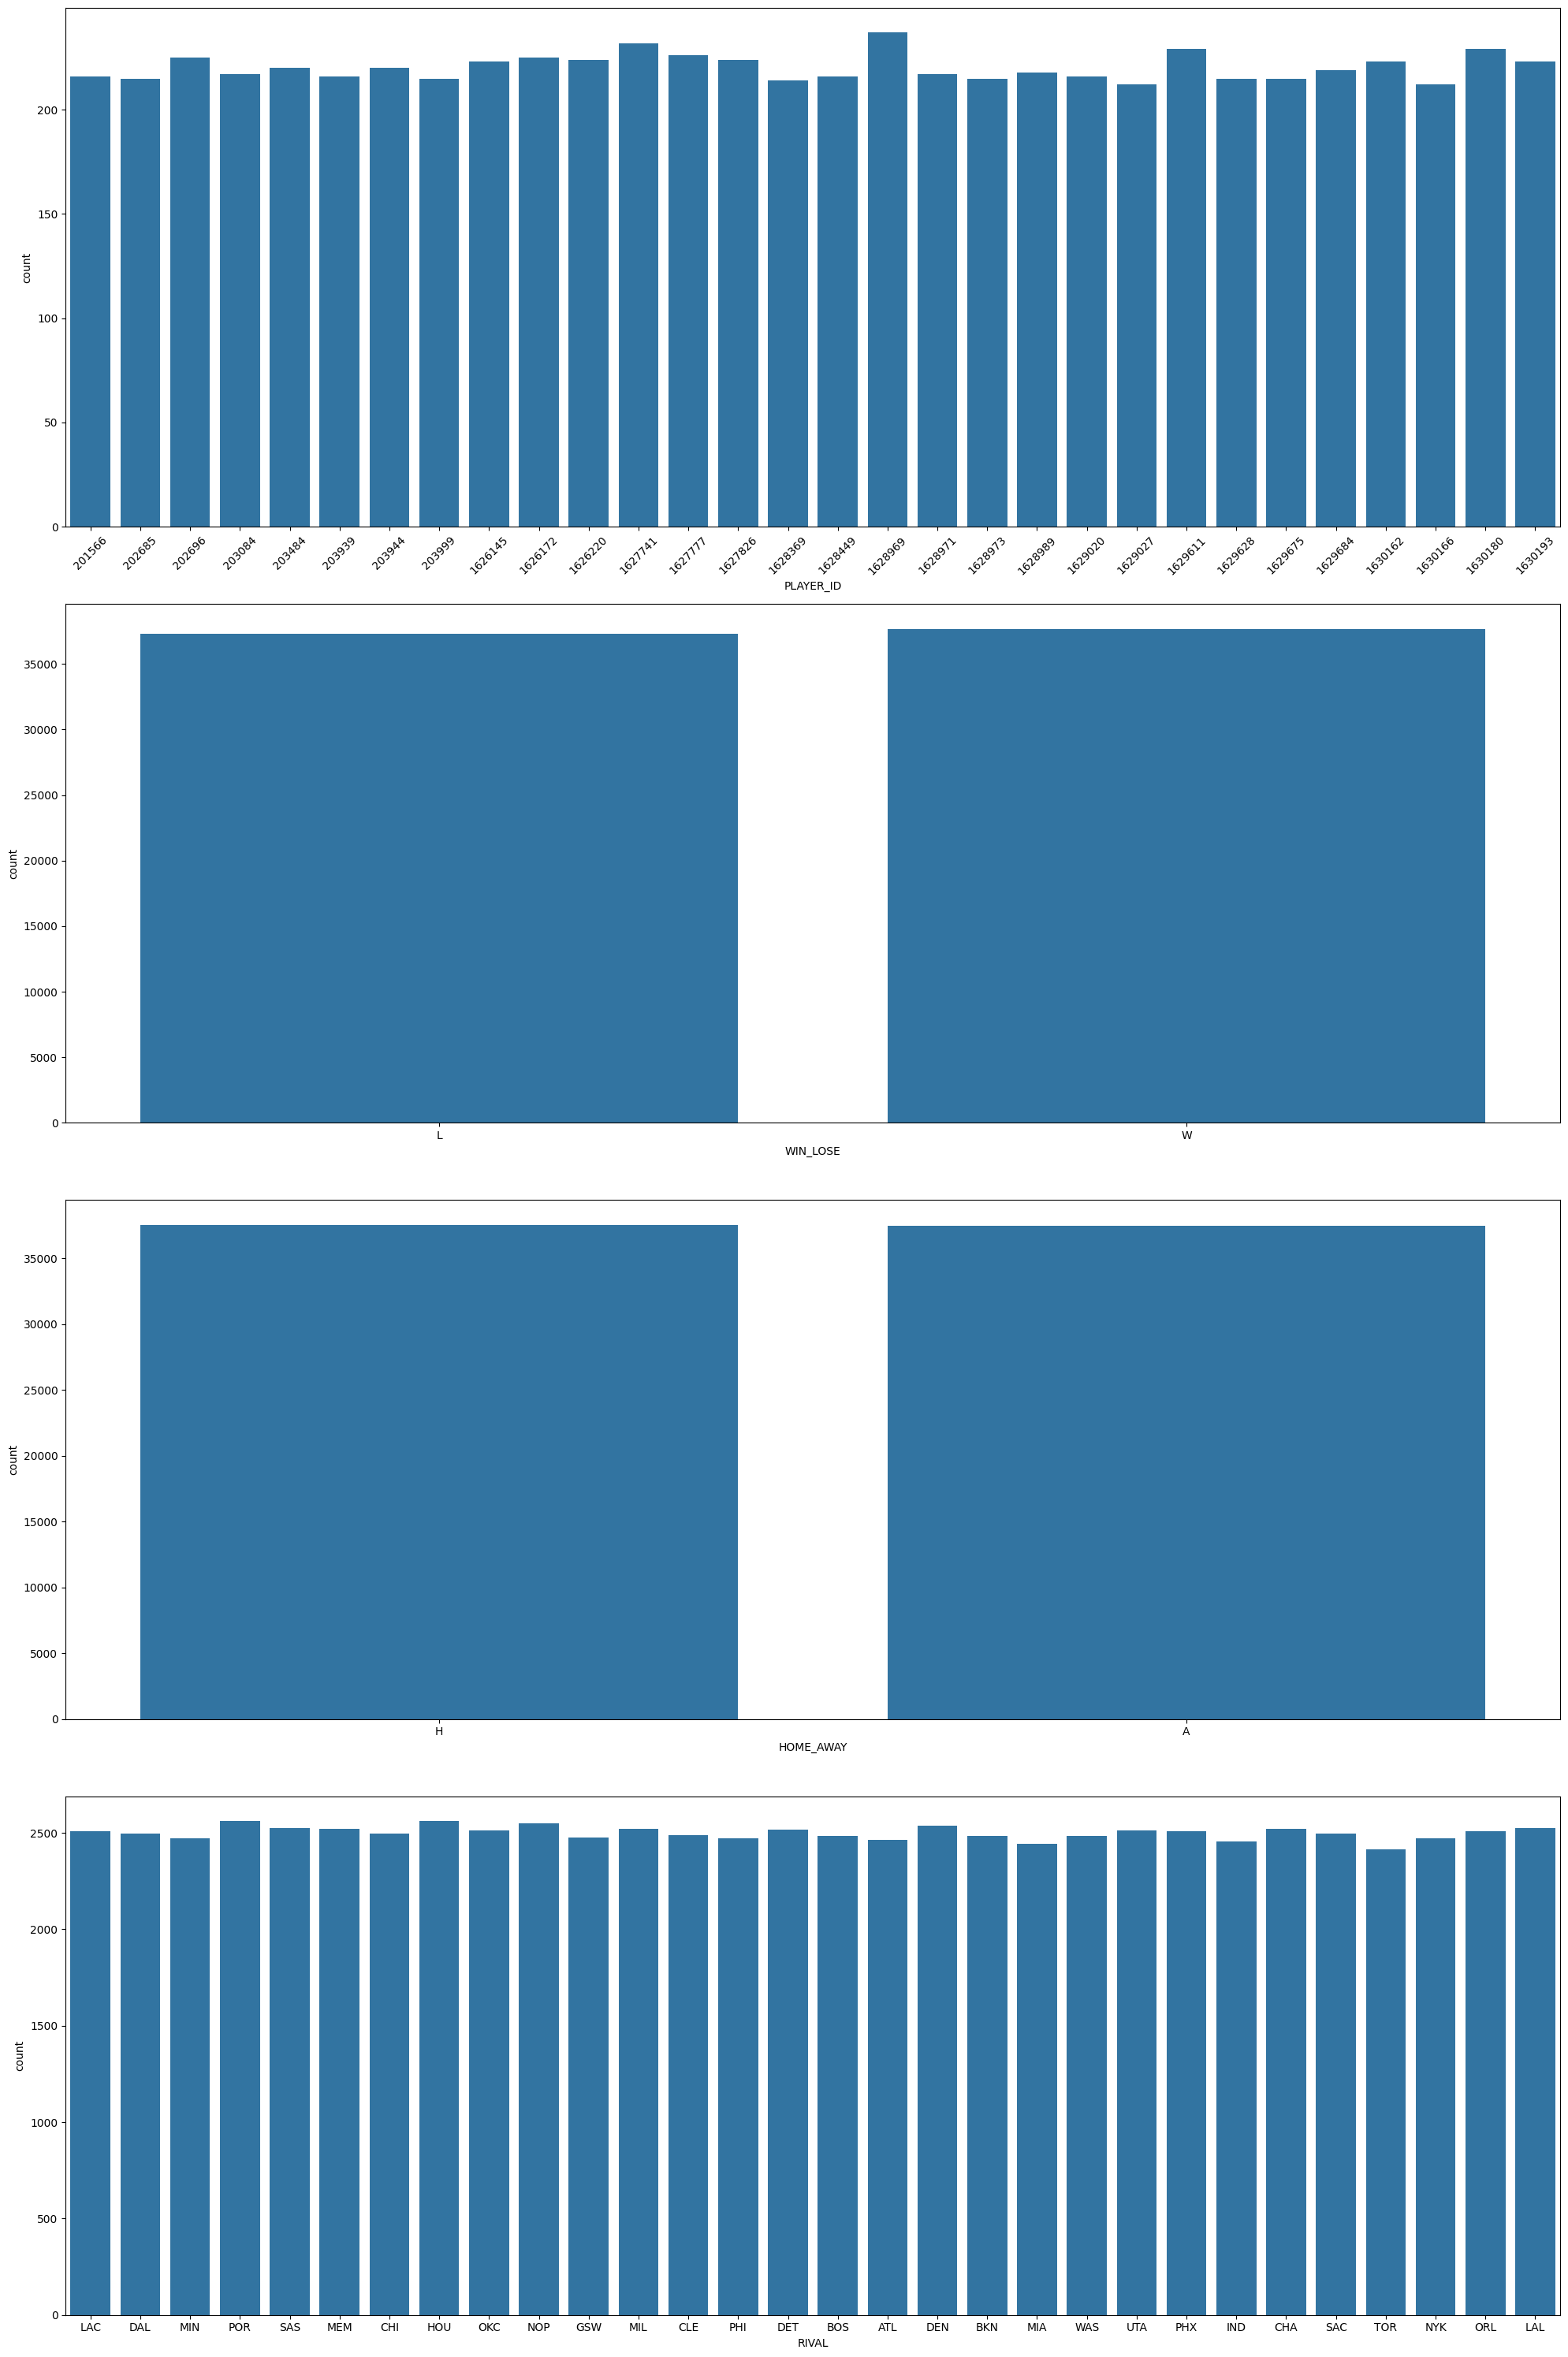

In [26]:
#Básicamente seria un análisis bastante similar al que se hizo anteriormente
#durante el análisis descriptivo.

#Ya que hay 784 jugadores sólo se tomará el Top 30 para una mejor visualización
top_30_jugadores = players_data['PLAYER_ID'].value_counts().head(30).index
top_30_jugadores = players_data[players_data['PLAYER_ID'].isin(top_30_jugadores)]

fig, axis = plt.subplots(4,1, figsize = (20, 30))

sns.countplot(ax = axis[0], data = top_30_jugadores, x = 'PLAYER_ID')
axis[0].tick_params(axis='x', rotation=45)

sns.countplot(ax = axis[1], data = players_data, x = 'WL').set(xlabel = 'WIN_LOSE')
sns.countplot(ax = axis[2], data = players_data, x = 'HOME_AWAY')
sns.countplot(ax = axis[3], data = players_data, x = 'RIVAL')

plt.tight_layout()

plt.show()

In [27]:
top_player_id = players_data['PLAYER_ID'].value_counts().head(10).index.tolist()
cantidad_juegos = players_data['PLAYER_ID'].value_counts().head(10).values.tolist()

i=0
print(f'Los jugadores con más partidos en las 3 temporadas fueron:\n')
for jugador in top_player_id:
    
    print(f'- {players_dict[jugador]} con {cantidad_juegos[i]} partidos')
    i += 1

Los jugadores con más partidos en las 3 temporadas fueron:

- Mikal Bridges con 237 partidos
- Buddy Hield con 232 partidos
- Terance Mann con 229 partidos
- Saddiq Bey con 229 partidos
- Georges Niang con 226 partidos
- Kevon Looney con 225 partidos
- Nikola Vucevic con 225 partidos
- Ivica Zubac con 224 partidos
- Royce O'Neale con 224 partidos
- Immanuel Quickley con 223 partidos


In [28]:
top_rival = players_data['RIVAL'].value_counts().head(10).index.tolist()
cantidad_registros_rival = players_data['RIVAL'].value_counts().head(10).values.tolist()

i=0
print(f'Los equipos con más registros de sus jugadores para la columna RIVAL son:\n')
for rival in top_rival:
    
    print(f'- {rival} con {cantidad_registros_rival[i]} partidos')
    i += 1

Los equipos con más registros de sus jugadores para la columna RIVAL son:

- HOU con 2562 partidos
- POR con 2561 partidos
- NOP con 2548 partidos
- DEN con 2537 partidos
- LAL con 2526 partidos
- SAS con 2526 partidos
- MEM con 2522 partidos
- MIL con 2521 partidos
- CHA con 2520 partidos
- DET con 2516 partidos


- Los registros están bastante parejos entre juegos Ganados y Perdidos al igual que los encuentros de Local y Visitante.

Variables Numéricas

In [29]:
players_data.columns

Index(['PLAYER_ID', 'WL', 'PTS', 'HOME_AWAY', 'MIN_PROM', 'FGM_PROM',
       'FGA_PROM', 'FG3M_PROM', 'FG3A_PROM', 'FTM_PROM', 'FTA_PROM',
       'OREB_PROM', 'DREB_PROM', 'AST_PROM', 'TOV_PROM', 'STL_PROM',
       'BLK_PROM', 'BLKA_PROM', 'PF_PROM', 'PFD_PROM', 'PTS_PROM',
       'PLUS_MINUS_PROM', 'PTSRTeam_PROM', 'PTSTeam_PROM', 'W_PCTTeam_PROM',
       'RIVAL'],
      dtype='object')

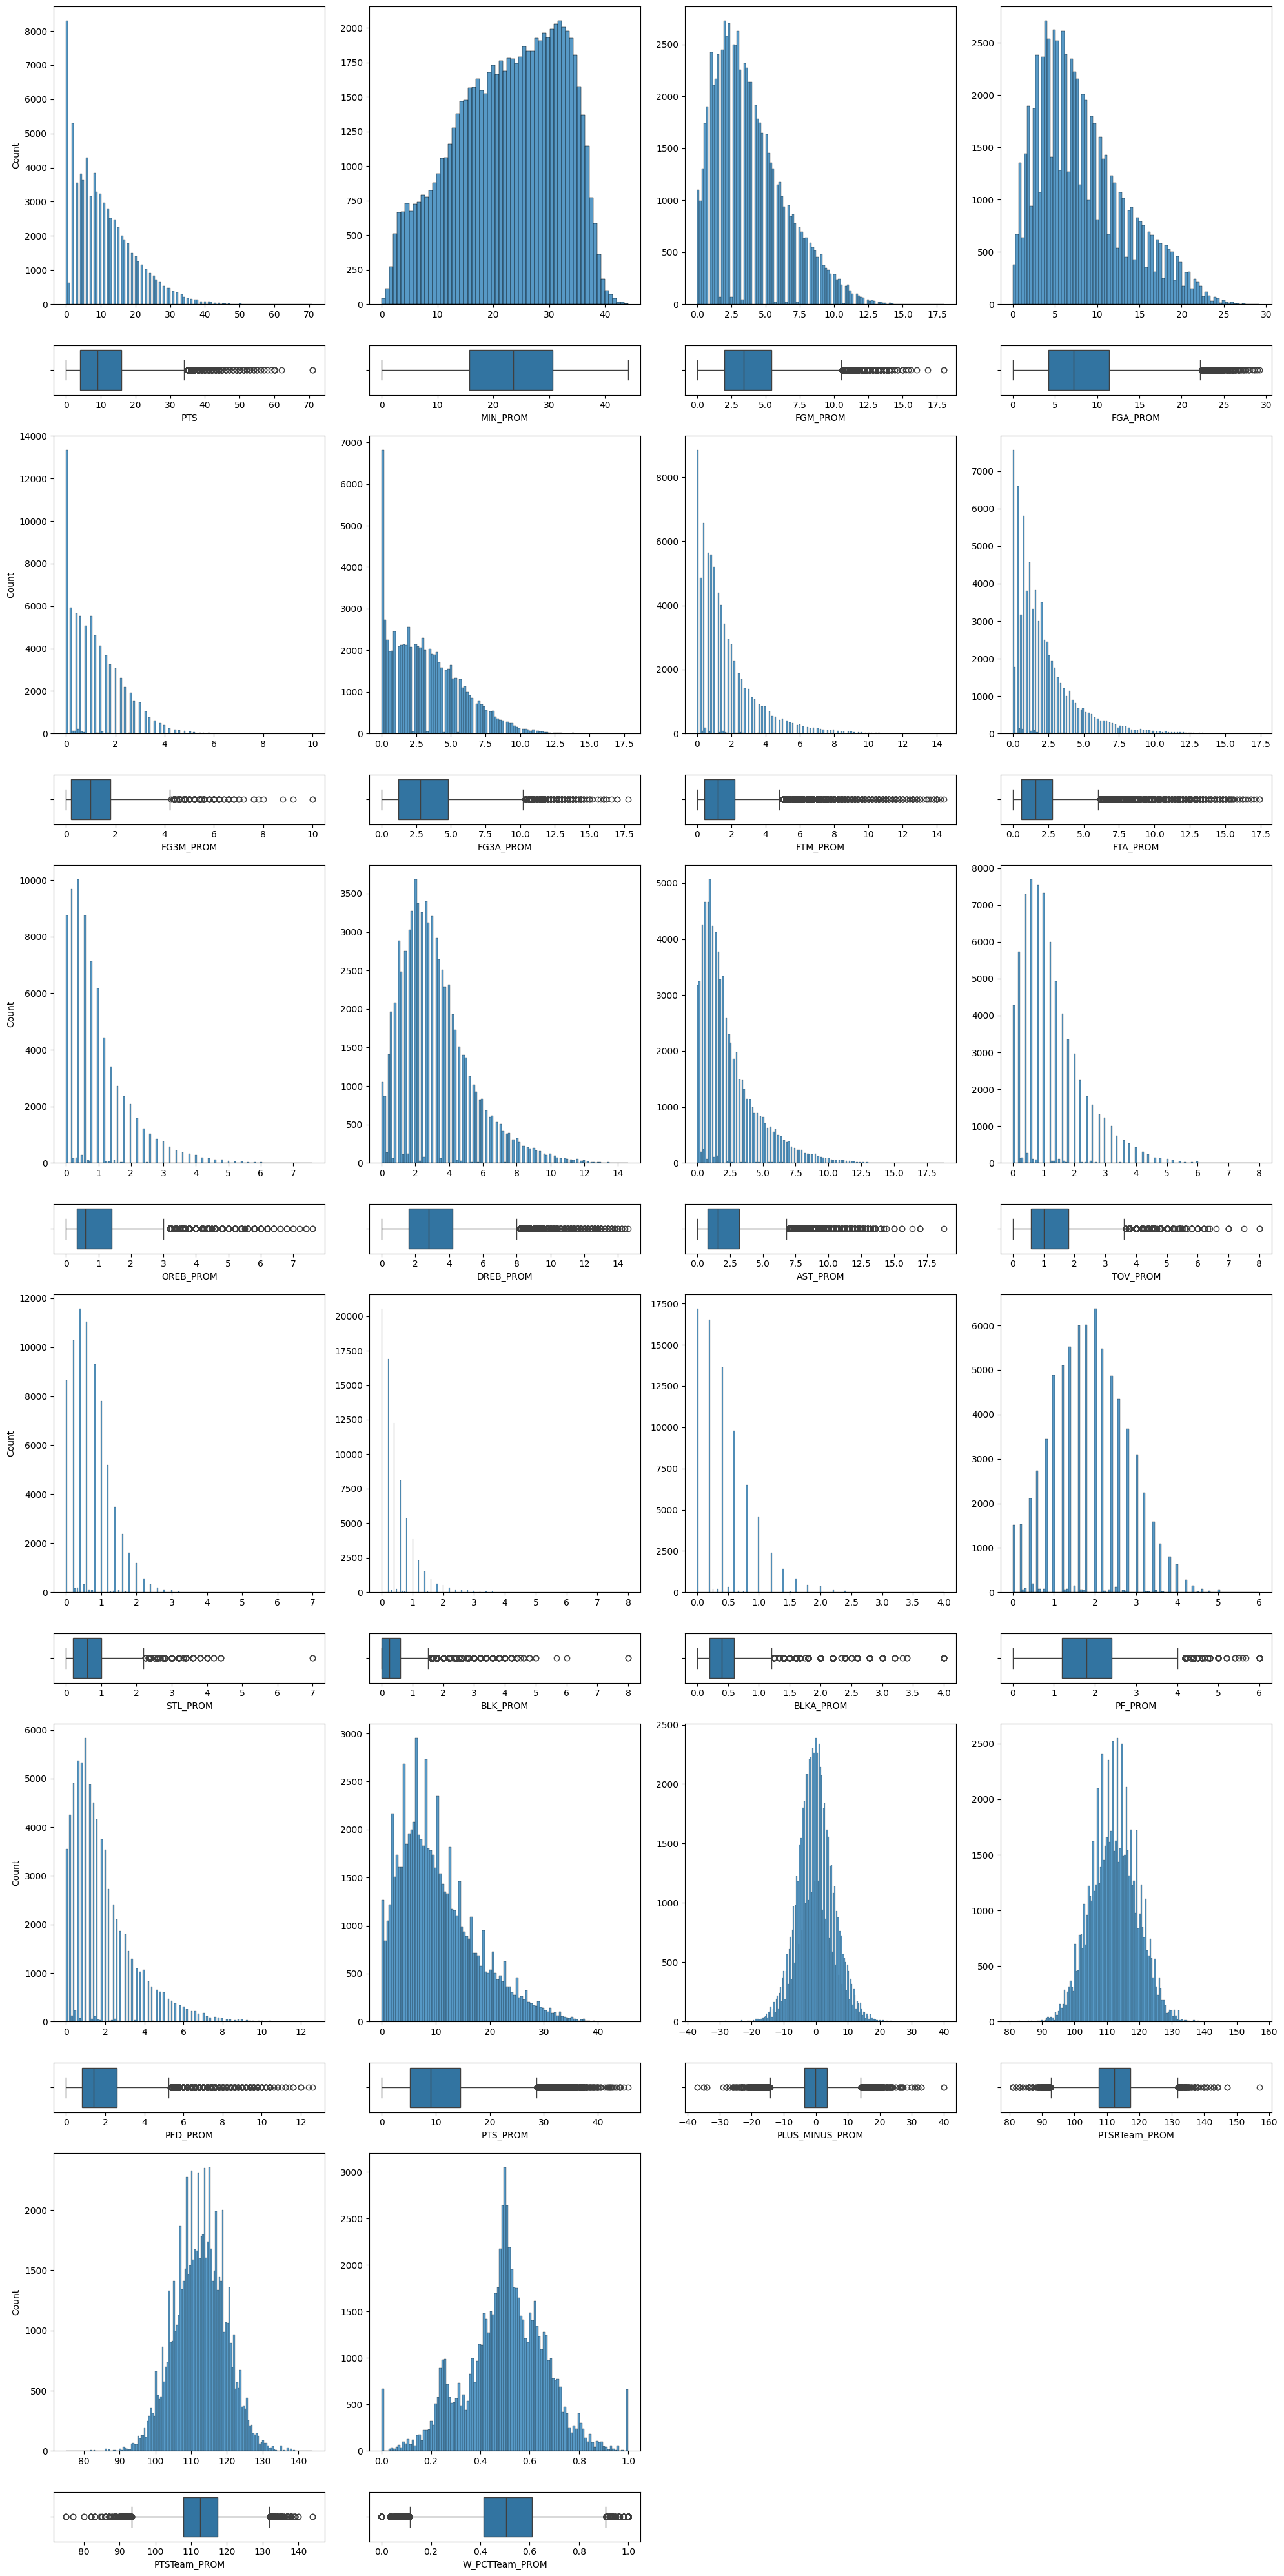

In [30]:
fig, axis = plt.subplots(12, 4, figsize = (20, 40), gridspec_kw={'height_ratios': [6,1,6,1,6,1,6,1,6,1,6,1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0, 0], data = players_data, x = "PTS").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = players_data, x = "PTS")

sns.histplot(ax = axis[0, 1], data = players_data, x = "MIN_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = players_data, x = "MIN_PROM")

sns.histplot(ax = axis[0, 2], data = players_data, x = "FGM_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 2], data = players_data, x = "FGM_PROM")

sns.histplot(ax = axis[0, 3], data = players_data, x = "FGA_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 3], data = players_data, x = "FGA_PROM")

###

sns.histplot(ax = axis[2, 0], data = players_data, x = "FG3M_PROM").set(xlabel = None)
sns.boxplot(ax = axis[3, 0], data = players_data, x = "FG3M_PROM")

sns.histplot(ax = axis[2, 1], data = players_data, x = "FG3A_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 1], data = players_data, x = "FG3A_PROM")

sns.histplot(ax = axis[2, 2], data = players_data, x = "FTM_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 2], data = players_data, x = "FTM_PROM")

sns.histplot(ax = axis[2, 3], data = players_data, x = "FTA_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 3], data = players_data, x = "FTA_PROM")

###

sns.histplot(ax = axis[4, 0], data = players_data, x = "OREB_PROM").set(xlabel = None)
sns.boxplot(ax = axis[5, 0], data = players_data, x = "OREB_PROM")

sns.histplot(ax = axis[4, 1], data = players_data, x = "DREB_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 1], data = players_data, x = "DREB_PROM")

sns.histplot(ax = axis[4, 2], data = players_data, x = "AST_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 2], data = players_data, x = "AST_PROM")

sns.histplot(ax = axis[4, 3], data = players_data, x = "TOV_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 3], data = players_data, x = "TOV_PROM")

###

sns.histplot(ax = axis[6, 0], data = players_data, x = "STL_PROM").set(xlabel = None)
sns.boxplot(ax = axis[7, 0], data = players_data, x = "STL_PROM")

sns.histplot(ax = axis[6, 1], data = players_data, x = "BLK_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[7, 1], data = players_data, x = "BLK_PROM")

sns.histplot(ax = axis[6, 2], data = players_data, x = "BLKA_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[7, 2], data = players_data, x = "BLKA_PROM")

sns.histplot(ax = axis[6, 3], data = players_data, x = "PF_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[7, 3], data = players_data, x = "PF_PROM")

###

sns.histplot(ax = axis[8, 0], data = players_data, x = "PFD_PROM").set(xlabel = None)
sns.boxplot(ax = axis[9, 0], data = players_data, x = "PFD_PROM")

sns.histplot(ax = axis[8, 1], data = players_data, x = "PTS_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[9, 1], data = players_data, x = "PTS_PROM")

sns.histplot(ax = axis[8, 2], data = players_data, x = "PLUS_MINUS_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[9, 2], data = players_data, x = "PLUS_MINUS_PROM")

sns.histplot(ax = axis[8, 3], data = players_data, x = "PTSRTeam_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[9, 3], data = players_data, x = "PTSRTeam_PROM")

###

sns.histplot(ax = axis[10, 0], data = players_data, x = "PTSTeam_PROM").set(xlabel = None)
sns.boxplot(ax = axis[11, 0], data = players_data, x = "PTSTeam_PROM")

sns.histplot(ax = axis[10, 1], data = players_data, x = "W_PCTTeam_PROM").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[11, 1], data = players_data, x = "W_PCTTeam_PROM")


subplots_remove = [axis[10, 2], axis[11, 2], axis[10, 3], axis[11, 3]]

for ax in subplots_remove:

    fig.delaxes(ax)

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

- La variable a predecir "PTS" presenta sesgo hacia la izquierda y con outliers aprox. desde 35 en adelante.
- La variable de MIN_PROM no presenta outliers, en gral presenta simetría.
- FGM_PROM, FGA_PROM, FG3M_PROM, FG3A_PROM, FTM_PROM, FTA_PROM, OREB_PROM, DREB_PROM, AST_PROM, TOV_PROM, STL_PROM, 
  BLK_PROM, BLKA_PROM, PFD_PROM, PTS_PROM presentan sesgo hacia la izquierda y outliers a su derecha.
- PF_PROM presenta simetría cercana a la normal, además presenta outliers a la derecha.
- PLUS_MINUS_PROM, PTSRTeam_PROM, PTSTeam_PROM, W_PCTTeam_PROM presentan bastante simetría, siendo cercana a la distribución normal,
  además todas tienen outliers a su izquierda y derecha.
- Es importante destacar que no se observa en ninguno de los casos valores que no tengan congruencia con la realidad del juego, es decir, que se puedan desestimar por carecer de sentido físico real.


- #### Análisis Multivariante

Numérico-Numérico

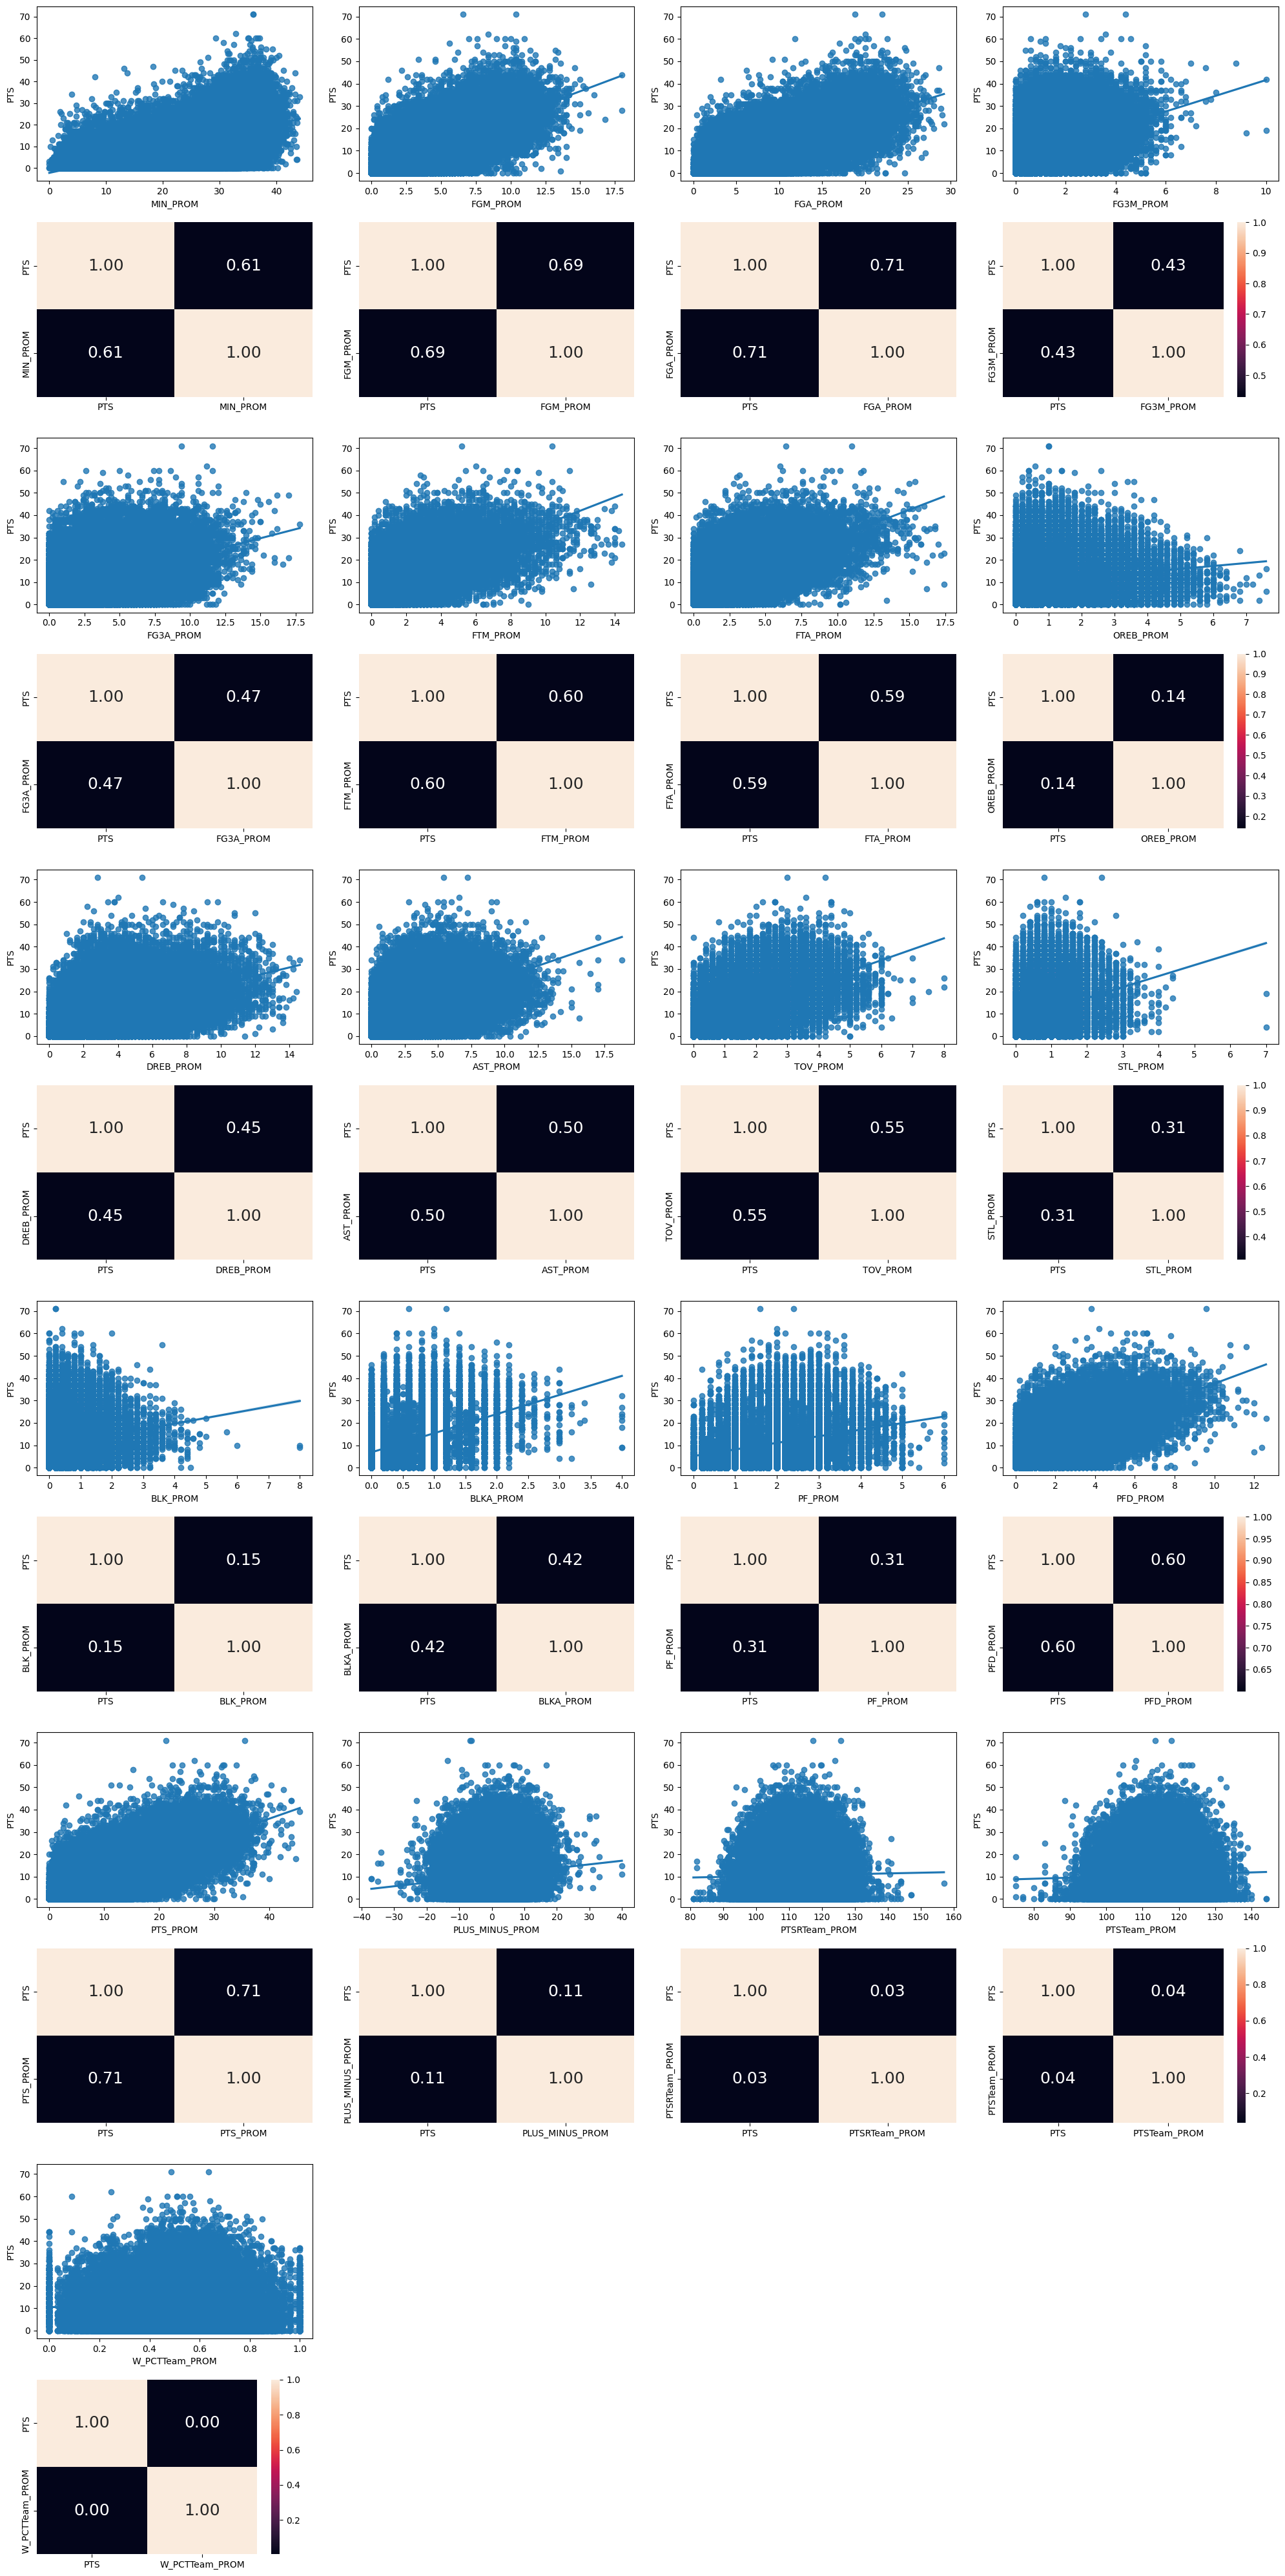

In [31]:
fig, axis = plt.subplots(12, 4, figsize = (20, 40))

sns.regplot(ax = axis[0,0], data = players_data, x = 'MIN_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'MIN_PROM']].corr(), ax = axis[1,0], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[0,1], data = players_data, x = 'FGM_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'FGM_PROM']].corr(), ax = axis[1,1], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[0,2], data = players_data, x = 'FGA_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'FGA_PROM']].corr(), ax = axis[1,2], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[0,3], data = players_data, x = 'FG3M_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'FG3M_PROM']].corr(), ax = axis[1,3], annot = True, fmt = ".2f", annot_kws={"size": 18})

####

sns.regplot(ax = axis[2,0], data = players_data, x = 'FG3A_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'FG3A_PROM']].corr(), ax = axis[3,0], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[2,1], data = players_data, x = 'FTM_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'FTM_PROM']].corr(), ax = axis[3,1], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[2,2], data = players_data, x = 'FTA_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'FTA_PROM']].corr(), ax = axis[3,2], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[2,3], data = players_data, x = 'OREB_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'OREB_PROM']].corr(), ax = axis[3,3], annot = True, fmt = ".2f", annot_kws={"size": 18})


####

sns.regplot(ax = axis[4,0], data = players_data, x = 'DREB_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'DREB_PROM']].corr(), ax = axis[5,0], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[4,1], data = players_data, x = 'AST_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'AST_PROM']].corr(), ax = axis[5,1], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[4,2], data = players_data, x = 'TOV_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'TOV_PROM']].corr(), ax = axis[5,2], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[4,3], data = players_data, x = 'STL_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'STL_PROM']].corr(), ax = axis[5,3], annot = True, fmt = ".2f", annot_kws={"size": 18})

####

sns.regplot(ax = axis[6,0], data = players_data, x = 'BLK_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'BLK_PROM']].corr(), ax = axis[7,0], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[6,1], data = players_data, x = 'BLKA_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'BLKA_PROM']].corr(), ax = axis[7,1], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[6,2], data = players_data, x = 'PF_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'PF_PROM']].corr(), ax = axis[7,2], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[6,3], data = players_data, x = 'PFD_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'PFD_PROM']].corr(), ax = axis[7,3], annot = True, fmt = ".2f", annot_kws={"size": 18})

####

sns.regplot(ax = axis[8,0], data = players_data, x = 'PTS_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'PTS_PROM']].corr(), ax = axis[9,0], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[8,1], data = players_data, x = 'PLUS_MINUS_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'PLUS_MINUS_PROM']].corr(), ax = axis[9,1], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[8,2], data = players_data, x = 'PTSRTeam_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'PTSRTeam_PROM']].corr(), ax = axis[9,2], annot = True, fmt = ".2f", cbar = False, annot_kws={"size": 18})

sns.regplot(ax = axis[8,3], data = players_data, x = 'PTSTeam_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'PTSTeam_PROM']].corr(), ax = axis[9,3], annot = True, fmt = ".2f", annot_kws={"size": 18})

####

sns.regplot(ax = axis[10,0], data = players_data, x = 'W_PCTTeam_PROM', y = 'PTS')
sns.heatmap(players_data[['PTS', 'W_PCTTeam_PROM']].corr(), ax = axis[11,0], annot = True, fmt = ".2f", annot_kws={"size": 18})

subplots_remove = [axis[10,1], axis[11,1], axis[10,2], axis[11,2], axis[10,3], axis[11,3]]

for ax in subplots_remove:

    fig.delaxes(ax)

plt.tight_layout()

plt.show()

- El porcentaje de victorias del equipo (W_PCT_Team_PROM) no tienen relación lineal con los PTS hechos por el jugador.
- PLUS_MINUS_PROM, OREB_PROM, BLK_PROM, PTSRTeam_PROM y PTS_Team_PROM, poseen relaciones lineales menores a 0.15 con los PTS pero las dos últimas son particularmente bajas de significancia, menor a 0.05.
- Las demás variables tienen relación lineal más relevante por encima de 0.3, las más significantes fueron FGA_PROM que representa el número de intentos de tiros de campos y PTS_PROM que representa el promedio de puntos de los últimos 5 partidos del jugador, ambas con un coeficiente de determinación de 0.71

En base a la baja relación de las variables W_PCTTeam_PROM, PTSRTeam_PROM y PTSTeam_PROM, no serán tomadas en cuenta para el entrenamiento del modelo.

In [32]:
players_data = players_data.drop(['W_PCTTeam_PROM', 'PTSRTeam_PROM', 'PTSTeam_PROM'], axis = 1)
players_data.columns

Index(['PLAYER_ID', 'WL', 'PTS', 'HOME_AWAY', 'MIN_PROM', 'FGM_PROM',
       'FGA_PROM', 'FG3M_PROM', 'FG3A_PROM', 'FTM_PROM', 'FTA_PROM',
       'OREB_PROM', 'DREB_PROM', 'AST_PROM', 'TOV_PROM', 'STL_PROM',
       'BLK_PROM', 'BLKA_PROM', 'PF_PROM', 'PFD_PROM', 'PTS_PROM',
       'PLUS_MINUS_PROM', 'RIVAL'],
      dtype='object')

- Categórico-Categórico

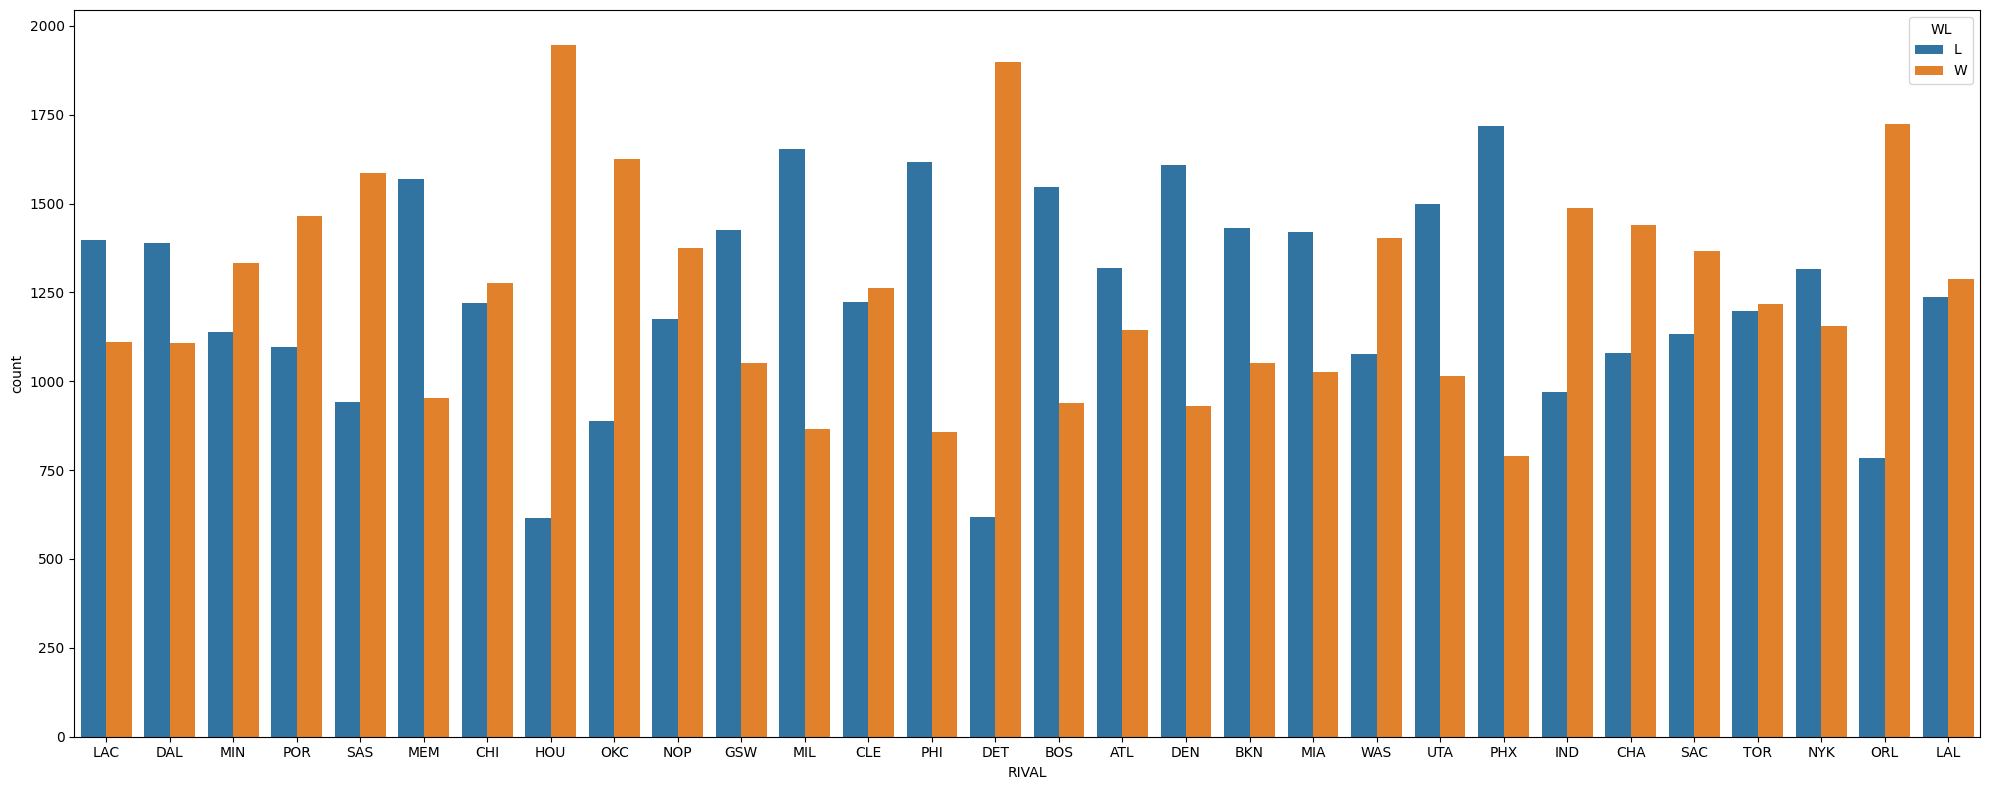

In [33]:
plt.figure(figsize = (20,8))

sns.countplot(data = players_data, x = 'RIVAL', hue = 'WL')

plt.tight_layout()

plt.show()

- En base a los registros de partido por cada jugador, el RIVAL contra el cual se tiene una mejor relación de partidos ganados vs perdidos fue Houston Rockets y le siguió Detroit Pistons.
- El RIVAL contra el cual se tiene una peor relación de partidos ganados vs perdidos fue Phoenix Suns y le siguió Milwaukee Bucks.

In [34]:
top_player_id = players_data['PLAYER_ID'].value_counts().head(30).index.tolist()
lista=[]
for id in top_player_id:
    
    lista.append(players_dict[id])

/tmp/ipykernel_1609/3140451385.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(lista, ha='right')


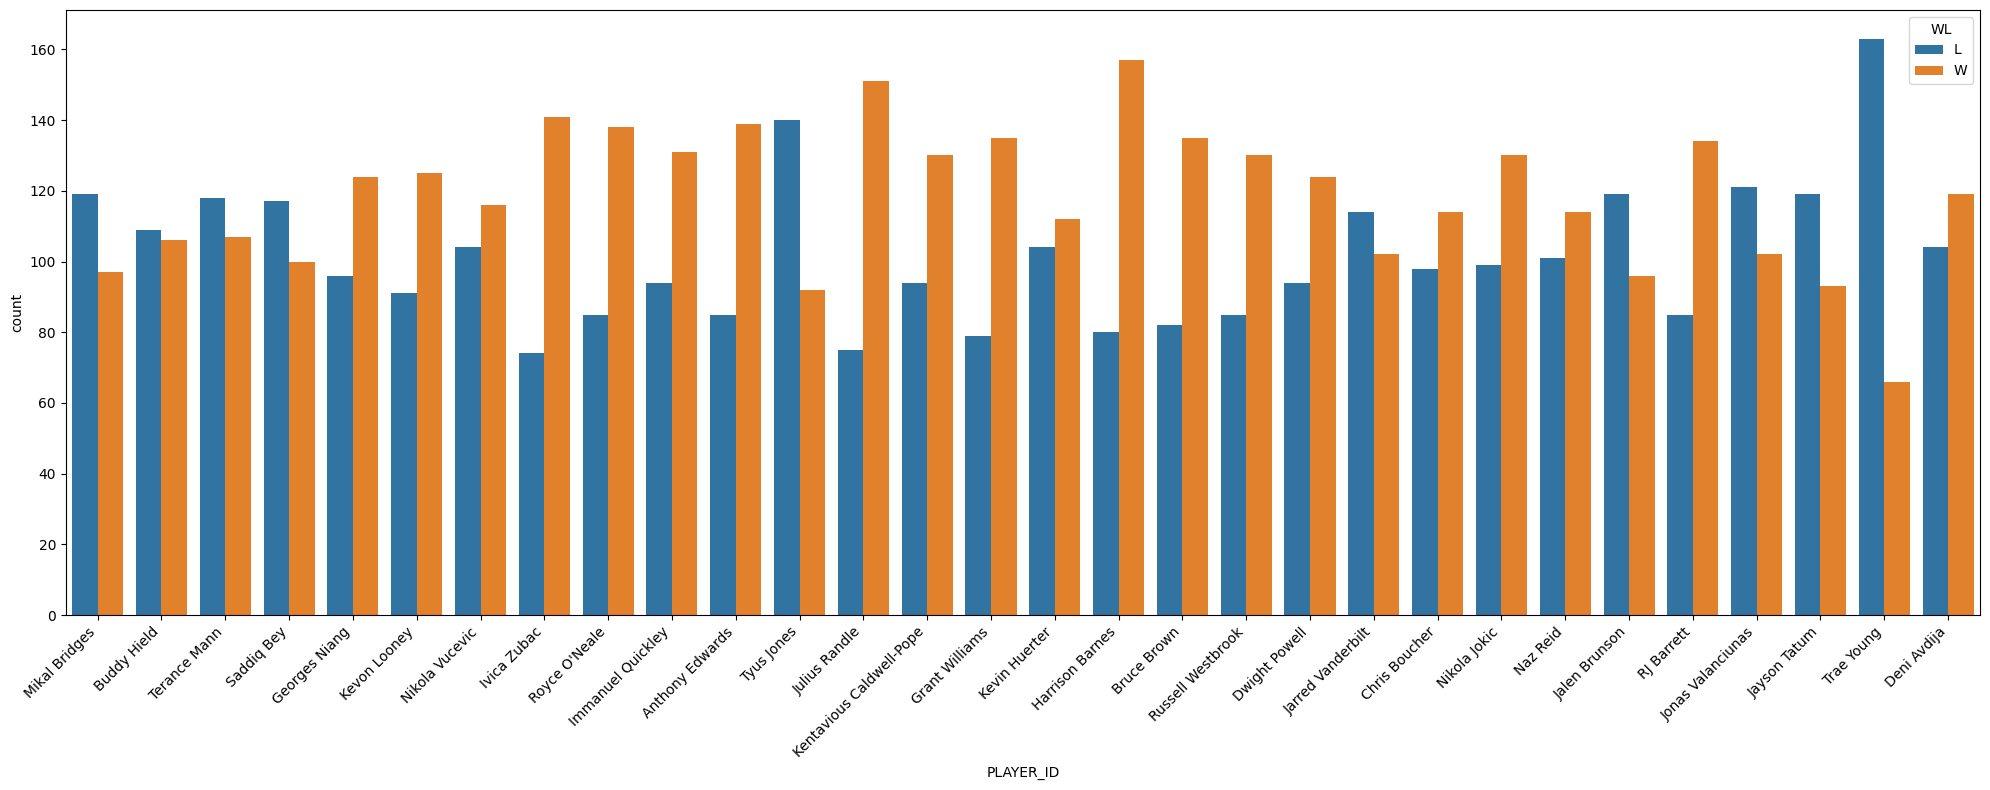

In [35]:
plt.figure(figsize = (20,8))

sns.countplot(data = top_30_jugadores, x = 'PLAYER_ID', hue = 'WL').tick_params(axis='x', rotation=45)

plt.gca().set_xticklabels(lista, ha='right')

plt.tight_layout()

plt.show()

Dentro del top 30 de jugadores con más partidos jugados en las tres temporadas estudiadas:
- Los jugadores con mejor relación de Victorias vs Derrotas fueron Harrison Barnes y Julius Randle.
- El jugador con peor relación de Victorias vs Derrotas fue por mucha diferencia Trae Young.

- Análisis Numérico-Categórico Completo:

In [36]:
players_data['WL'] = players_data['WL'].replace({'W':1,'L':0})
players_data['HOME_AWAY'] = players_data['HOME_AWAY'].replace({'H':1,'A':0})

/tmp/ipykernel_1609/1088422863.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  players_data['WL'] = players_data['WL'].replace({'W':1,'L':0})
/tmp/ipykernel_1609/1088422863.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  players_data['HOME_AWAY'] = players_data['HOME_AWAY'].replace({'H':1,'A':0})


In [37]:
team_abbre_dict_invertido = {v: k for k, v in team_abbre_dict.items()}
players_data['RIVAL'] = players_data['RIVAL'].replace(team_abbre_dict_invertido)

/tmp/ipykernel_1609/2506887788.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  players_data['RIVAL'] = players_data['RIVAL'].replace(team_abbre_dict_invertido)


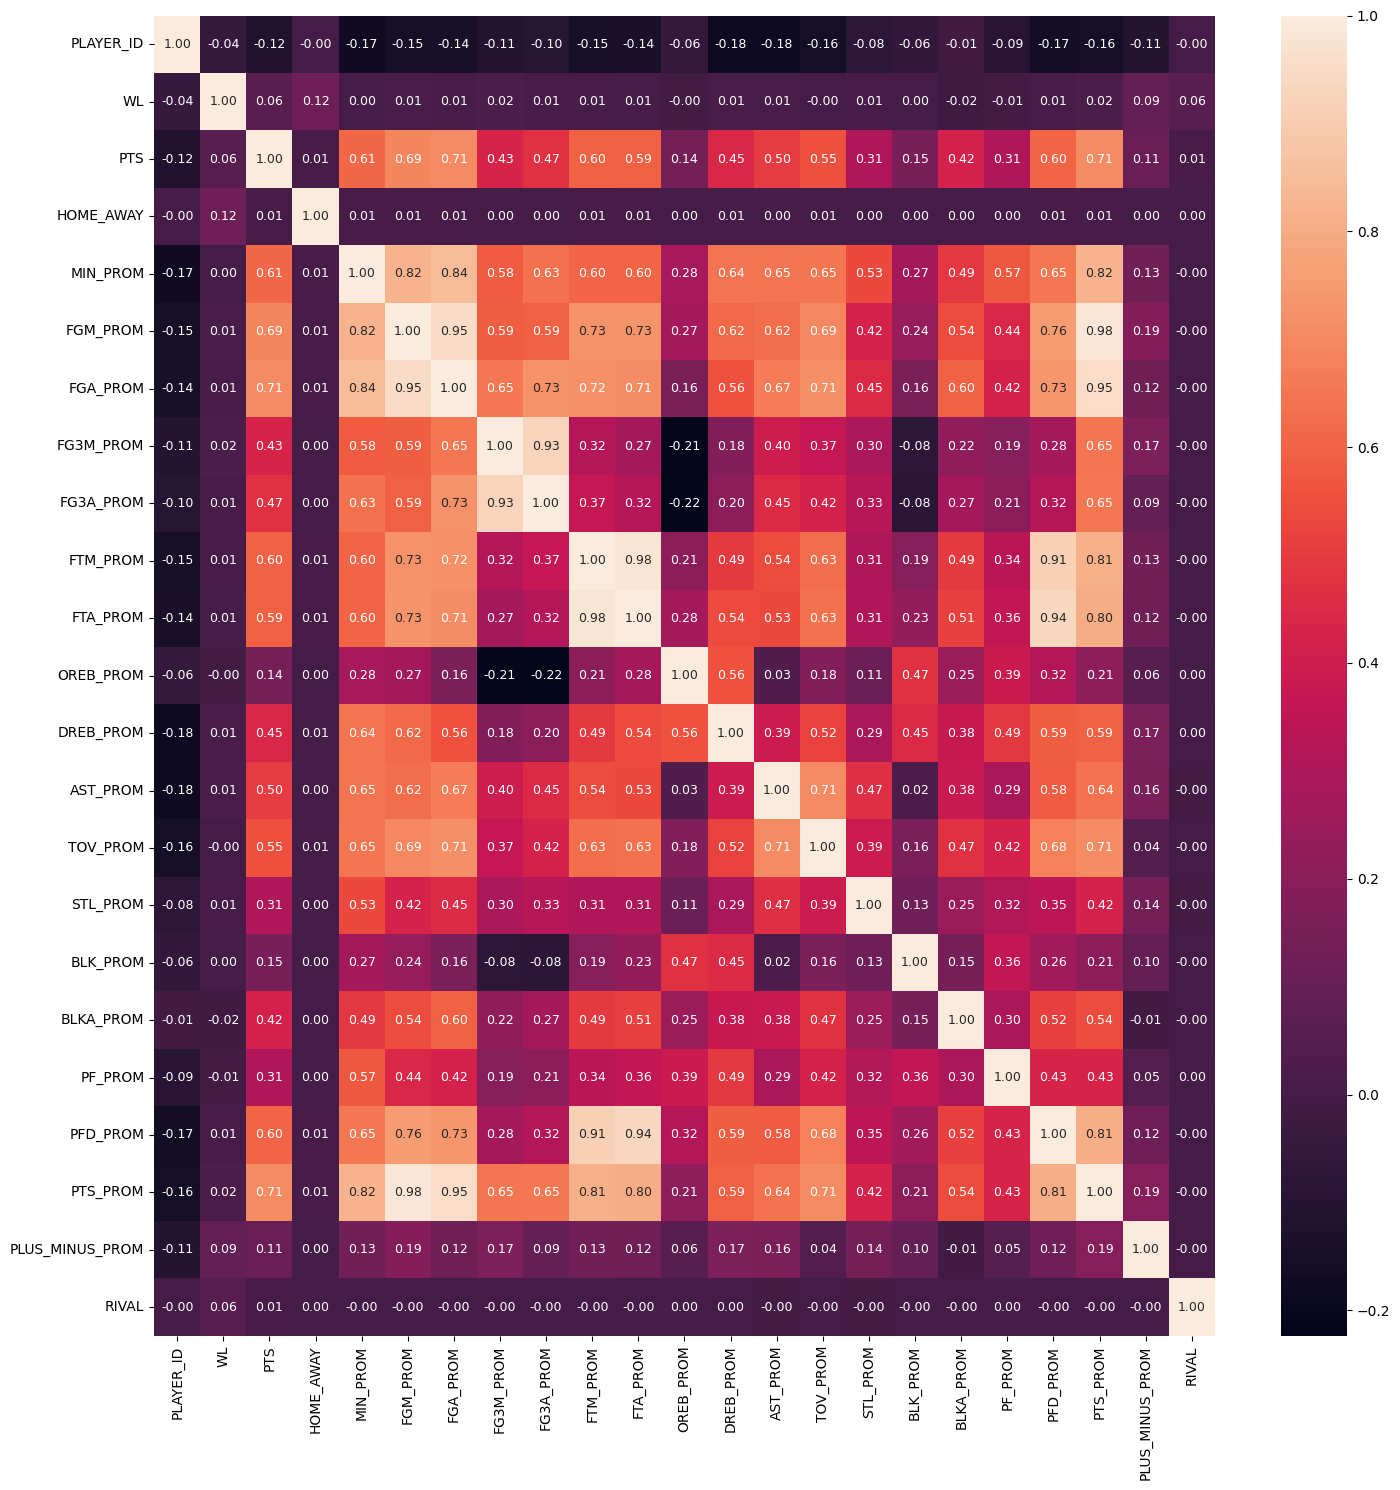

In [38]:
plt.figure(figsize = (15,15))

sns.heatmap(players_data[['PLAYER_ID', 'WL', 'PTS', 'HOME_AWAY', 'MIN_PROM', 'FGM_PROM',
       'FGA_PROM', 'FG3M_PROM', 'FG3A_PROM', 'FTM_PROM', 'FTA_PROM',
       'OREB_PROM', 'DREB_PROM', 'AST_PROM', 'TOV_PROM', 'STL_PROM',
       'BLK_PROM', 'BLKA_PROM', 'PF_PROM', 'PFD_PROM', 'PTS_PROM',
       'PLUS_MINUS_PROM', 'RIVAL']].corr(), annot = True, fmt = ".2f", annot_kws={'size': 9})

plt.tight_layout()
plt.show()

In [39]:
players_data[["WL","PTS"]].corr(method="spearman")

,WL,PTS
WL,1.000000,0.046553
PTS,0.046553,1.000000


In [40]:
players_data[["HOME_AWAY","PTS"]].corr(method="spearman")

,HOME_AWAY,PTS
HOME_AWAY,1.000000,0.005935
PTS,0.005935,1.000000


In [41]:
players_data[["RIVAL","PTS"]].corr(method="spearman")

,RIVAL,PTS
RIVAL,1.000000,0.010285
PTS,0.010285,1.000000


Debido a la baja correlación entre las variables WL, HOME_AWAY, RIVAL y la variable a predecir PTS, no se tomarán en cuenta
para lo que sigue de análisis.

In [42]:
players_data = players_data.drop(['HOME_AWAY','WL','RIVAL'],axis=1)
players_data.columns

Index(['PLAYER_ID', 'PTS', 'MIN_PROM', 'FGM_PROM', 'FGA_PROM', 'FG3M_PROM',
       'FG3A_PROM', 'FTM_PROM', 'FTA_PROM', 'OREB_PROM', 'DREB_PROM',
       'AST_PROM', 'TOV_PROM', 'STL_PROM', 'BLK_PROM', 'BLKA_PROM', 'PF_PROM',
       'PFD_PROM', 'PTS_PROM', 'PLUS_MINUS_PROM'],
      dtype='object')

Se Guarda el Dataframe con los datos ya limpios en un archivo .csv

In [74]:
#Se guarda el dataframe en el archivo .csv llamado "data_clean.csv"
players_data.to_csv('../data/processed/data_clean.csv', index=False)